# Introduction, Load Libraries and Data Set

In [1]:
# -----
# Notes
# -----

# Modelling steps:
# EDA - single variable
# EDA - bivariate analysis
# select evaluation method: accuracy?, recall?
# feature engineering
# Fit candidate models - Random Forest Classifier, Logisitic Regression, SVM
# Model evaluation: nested cross val

# Causes of Default / Signs of Default
# - lose job
# - get sick
# - change martital status
# - unexpected big expense
# - forget to make a payment
# - people getting into trouble and moving $ around

# Possible Constructed Features:
# - slope of bill vs slope of pay
# - variance in the payment amount in last 6 months
# - pay trend
# - small average usage and 2 zero payments in last 6 months
# - number of defaults in the past
# - extra cash ratio
# - limit bal ratio

# - bill amount over limit in last 6 months

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import math
import os
import statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

def roundup(x,y):
    return int(math.ceil(x / y)) * y

def rounddown(x,y):
    return int(math.floor(x / y)) * y

def simple_avg_fun(x):
    return (x.iloc[0] + x.iloc[1])/2

def pay_trend_fun(x):
    xvals = [1,2,3,4,5,6,7]
    yvals = [x.PAY_6,x.PAY_5,x.PAY_4,x.PAY_3,x.PAY_2,x.PAY_1,x.PAY_0]
    slope = stats.linregress(xvals,yvals).slope
    return slope

def bill_trend_fun(x):
    xvals = [1,2,3,4,5,6]
    yvals = [x.BILL_AMT6,x.BILL_AMT5,x.BILL_AMT4,x.BILL_AMT3,x.BILL_AMT2,x.BILL_AMT1]
    slope = stats.linregress(xvals,yvals).slope
    return slope

def payam_trend_fun(x):
    xvals = [1,2,3,4,5,6]
    yvals = [x.PAY_AMT6,x.PAY_AMT5,x.PAY_AMT4,x.PAY_AMT3,x.PAY_AMT2,x.PAY_AMT1]
    slope = stats.linregress(xvals,yvals).slope
    return slope

def payam_variance_fun(x):
    val = statistics.variance([x.PAY_AMT6,x.PAY_AMT5,x.PAY_AMT4,x.PAY_AMT3,x.PAY_AMT2,x.PAY_AMT1])
    return val

def pay_trend_fun(x):
    xvals = [1,2,3,4,5,6,7]
    yvals = [x.PAY_6,x.PAY_5,x.PAY_4,x.PAY_3,x.PAY_2,x.PAY_1,x.PAY_0]
    slope = stats.linregress(xvals,yvals).slope
    return slope

def pay_avg_fun(x):
    pay_last_3 = [x.PAY_2,x.PAY_1,x.PAY_0]
    val = statistics.mean(pay_last_3)
    return val

def customer_forgot(x):
    full_list = [x.PAY_AMT6,x.PAY_AMT5,x.PAY_AMT4,x.PAY_AMT3,x.PAY_AMT2,x.PAY_AMT1]
    last_3_list = [x.BILL_AMT3,x.BILL_AMT2,x.BILL_AMT1]
    val = '0'
    if (statistics.mean(last_3_list)/x.LIMIT_BAL) < 0.1 and full_list.count(0) > 1:
        val = '1'
    return val

def num_past_def_fun(x):
    val = 0
    if x.PAY_AMT5 < 0.03*x.BILL_AMT6:
        val = val + 1
    if x.PAY_AMT4 < 0.03*x.BILL_AMT5:
        val = val + 1
    if x.PAY_AMT3 < 0.03*x.BILL_AMT4:
        val = val + 1
    if x.PAY_AMT2 < 0.03*x.BILL_AMT3:
        val = val + 1
    if x.PAY_AMT1 < 0.03*x.BILL_AMT2:
        val = val + 1     
    return val

def extra_cash_ratio_fun(x):
    bill_list = [x.BILL_AMT1,x.BILL_AMT2,x.BILL_AMT3,x.BILL_AMT4,x.BILL_AMT5,x.BILL_AMT6]
    neg_bill_list = [i for i in bill_list if i < 0] 
    if len(neg_bill_list) > 0:
        val = abs(statistics.mean(neg_bill_list)/max(statistics.mean(bill_list),1))
    else:
        val = 0
    return val

def limit_bal_ratio_fun(x):
    bill_list = [x.BILL_AMT1,x.BILL_AMT2,x.BILL_AMT3,]
    val = statistics.mean(bill_list)/x.LIMIT_BAL
    return val

# Settings
pd.set_option('display.max_columns', 50)
os.chdir('C:/Users/darre/OneDrive/Documents/Cash_4_You')

In [3]:
df = pd.read_csv('Data_Set.csv')
df.columns = df.iloc[0]
df = df.iloc[1: , :]
df = df.reset_index(drop=True)

# Exploratory Data Analysis

## An Initial Look

In [4]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### We seem to have a reasonably clean looking data set here with no missing values. The object types are set to object which we will deal with later.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [6]:
# cleaning up target column labelling
df = df.rename(columns={'default payment next month': 'default_initial'})

In [7]:
{column: len(df[column].unique()) for column in df.columns}

{'ID': 30000,
 'LIMIT_BAL': 81,
 'SEX': 2,
 'EDUCATION': 7,
 'MARRIAGE': 4,
 'AGE': 56,
 'PAY_0': 11,
 'PAY_2': 11,
 'PAY_3': 11,
 'PAY_4': 11,
 'PAY_5': 10,
 'PAY_6': 10,
 'BILL_AMT1': 22723,
 'BILL_AMT2': 22346,
 'BILL_AMT3': 22026,
 'BILL_AMT4': 21548,
 'BILL_AMT5': 21010,
 'BILL_AMT6': 20604,
 'PAY_AMT1': 7943,
 'PAY_AMT2': 7899,
 'PAY_AMT3': 7518,
 'PAY_AMT4': 6937,
 'PAY_AMT5': 6897,
 'PAY_AMT6': 6939,
 'default_initial': 2}

In [8]:
{column: len(df[column].unique()) for column in df.columns}

{'ID': 30000,
 'LIMIT_BAL': 81,
 'SEX': 2,
 'EDUCATION': 7,
 'MARRIAGE': 4,
 'AGE': 56,
 'PAY_0': 11,
 'PAY_2': 11,
 'PAY_3': 11,
 'PAY_4': 11,
 'PAY_5': 10,
 'PAY_6': 10,
 'BILL_AMT1': 22723,
 'BILL_AMT2': 22346,
 'BILL_AMT3': 22026,
 'BILL_AMT4': 21548,
 'BILL_AMT5': 21010,
 'BILL_AMT6': 20604,
 'PAY_AMT1': 7943,
 'PAY_AMT2': 7899,
 'PAY_AMT3': 7518,
 'PAY_AMT4': 6937,
 'PAY_AMT5': 6897,
 'PAY_AMT6': 6939,
 'default_initial': 2}

### An initial correlation plot indicates some level of correlation between PAY_0, PAY_2, etc. and the target variable, but not otherwise particularly strong relationships between the various features and our target label.  We will do a more detailed investigation a little later on.

<IPython.core.display.Javascript object>


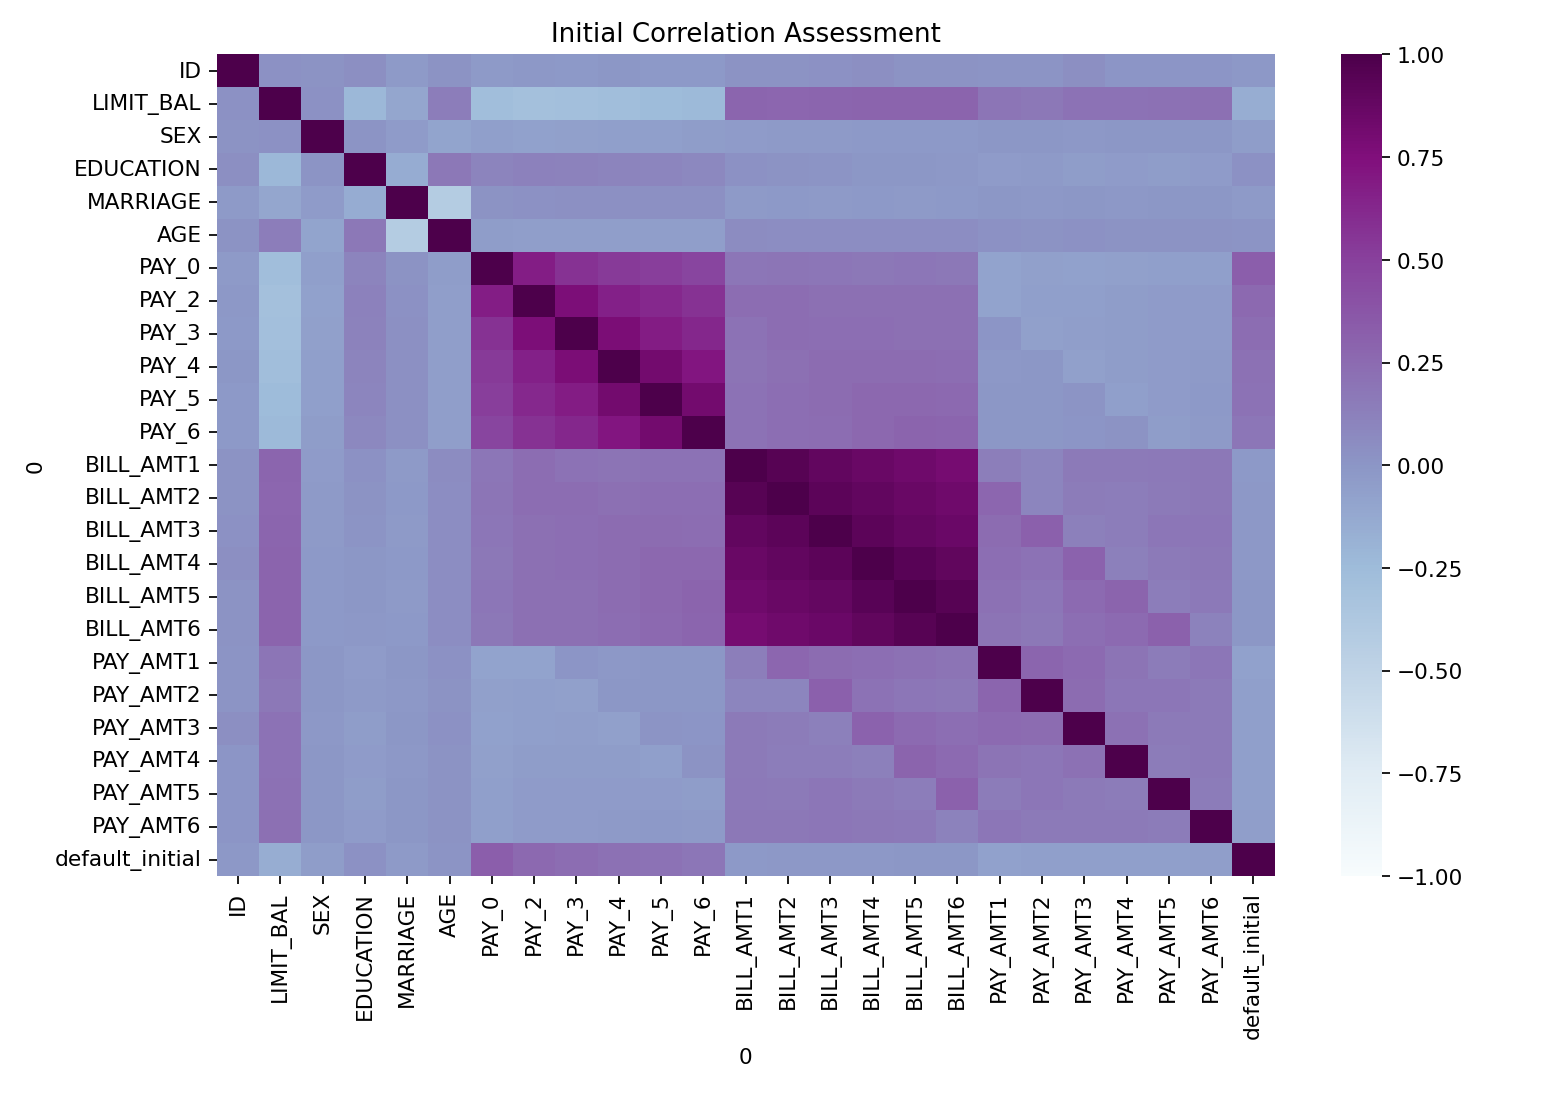

In [9]:
corr = df.corr()

plt.figure(figsize=(10,7))
sn.heatmap(corr, vmin=-1.0,cmap='BuPu')
plt.title("Initial Correlation Assessment")
plt.tight_layout()
plt.show()

## Single Variable Analysis

### default_initial: In general, default_initial looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.¶

In [10]:
df["default_initial"] = df["default_initial"].astype('category')
df["default_initial"].dtype

CategoricalDtype(categories=['0', '1'], ordered=False, categories_dtype=object)

In [11]:
df["default_initial"].describe()

count     30000
unique        2
top           0
freq      23364
Name: default_initial, dtype: object

In [12]:
DEFAULT_counts = df["default_initial"].value_counts()
DEFAULT_types = ['No_Default','Default']

<IPython.core.display.Javascript object>


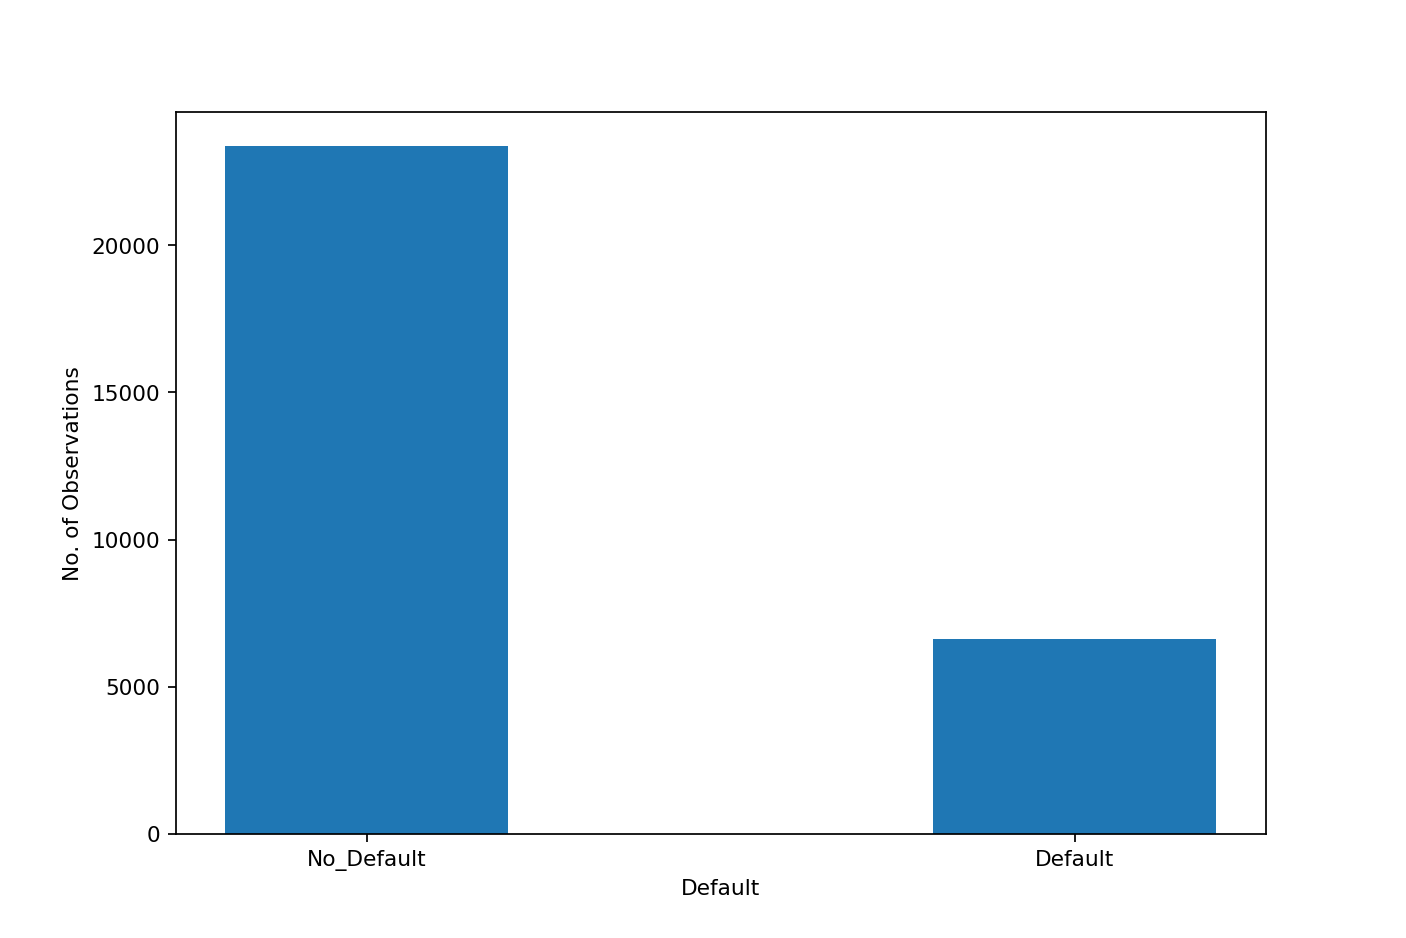

In [13]:
fig = plt.figure(figsize = (9, 6))
plt.bar(DEFAULT_types, DEFAULT_counts,
        width = 0.4) 
plt.xlabel("Default")
plt.ylabel("No. of Observations")
plt.show()

### LIMIT_BAL: In general, LIMIT_BAL looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.¶

In [14]:
df.LIMIT_BAL = pd.to_numeric(df.LIMIT_BAL, errors='coerce')
df.LIMIT_BAL.dtype

dtype('int64')

In [15]:
df.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

<IPython.core.display.Javascript object>


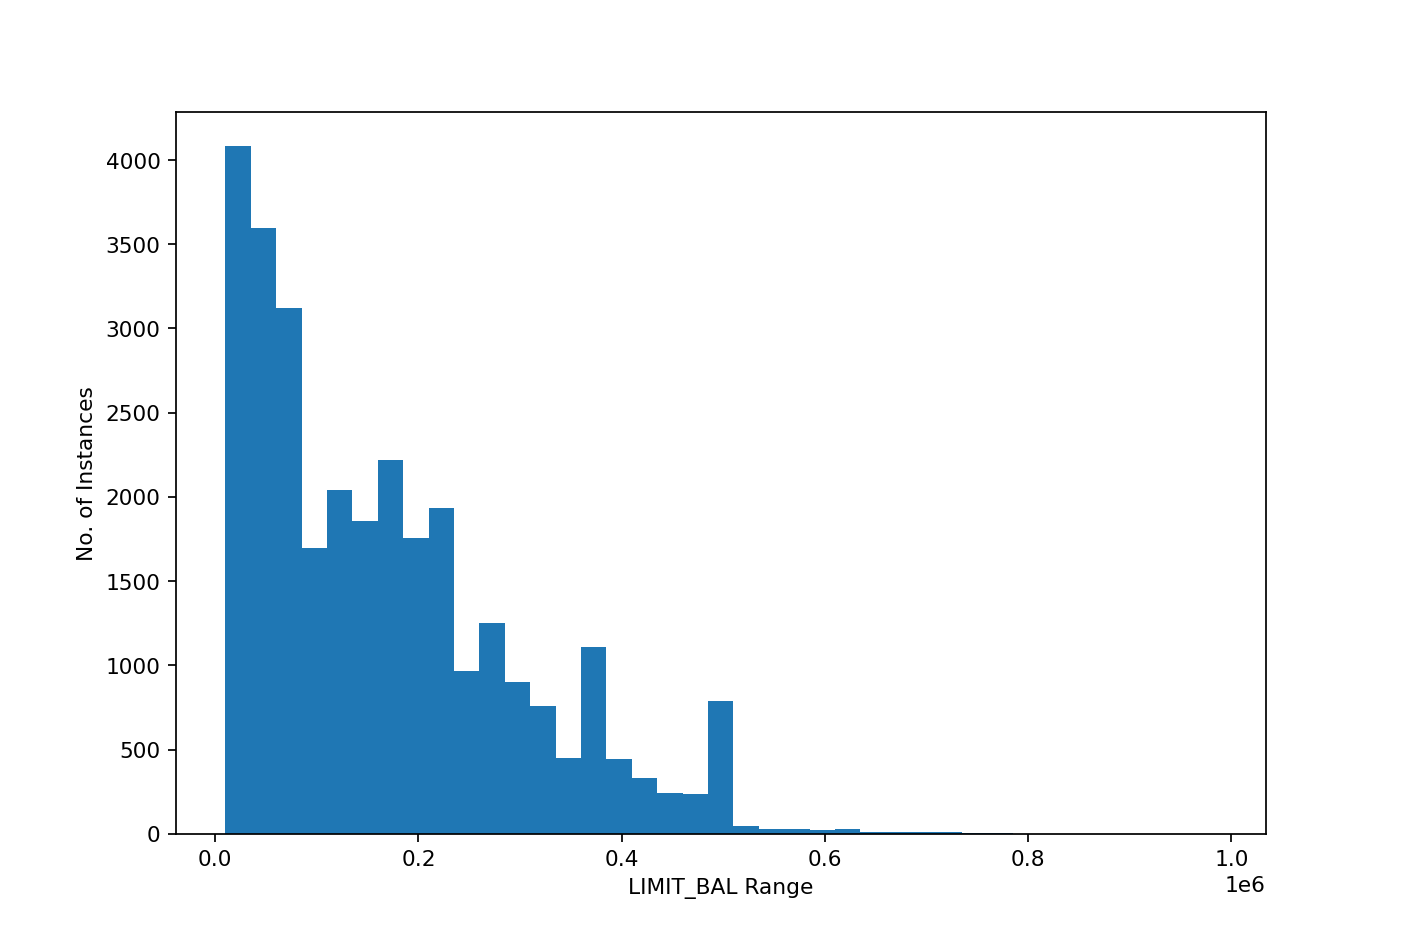

In [16]:
bins_mod = list(range(10000, 1000000,25000))
plt.figure(figsize=(9,6))
plt.hist(df.LIMIT_BAL,
         bins = bins_mod)
plt.xlabel("LIMIT_BAL Range")
plt.ylabel("No. of Instances")
plt.show()

### SEX: In general, SEX looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.¶

In [17]:
df["SEX"] = df["SEX"].astype('category')
df["SEX"].dtype

CategoricalDtype(categories=['1', '2'], ordered=False, categories_dtype=object)

In [18]:
df["SEX"].describe()

count     30000
unique        2
top           2
freq      18112
Name: SEX, dtype: object

In [19]:
SEX_counts = df["SEX"].value_counts()
SEX_types = ['Sex_1','Sex_2']

<IPython.core.display.Javascript object>


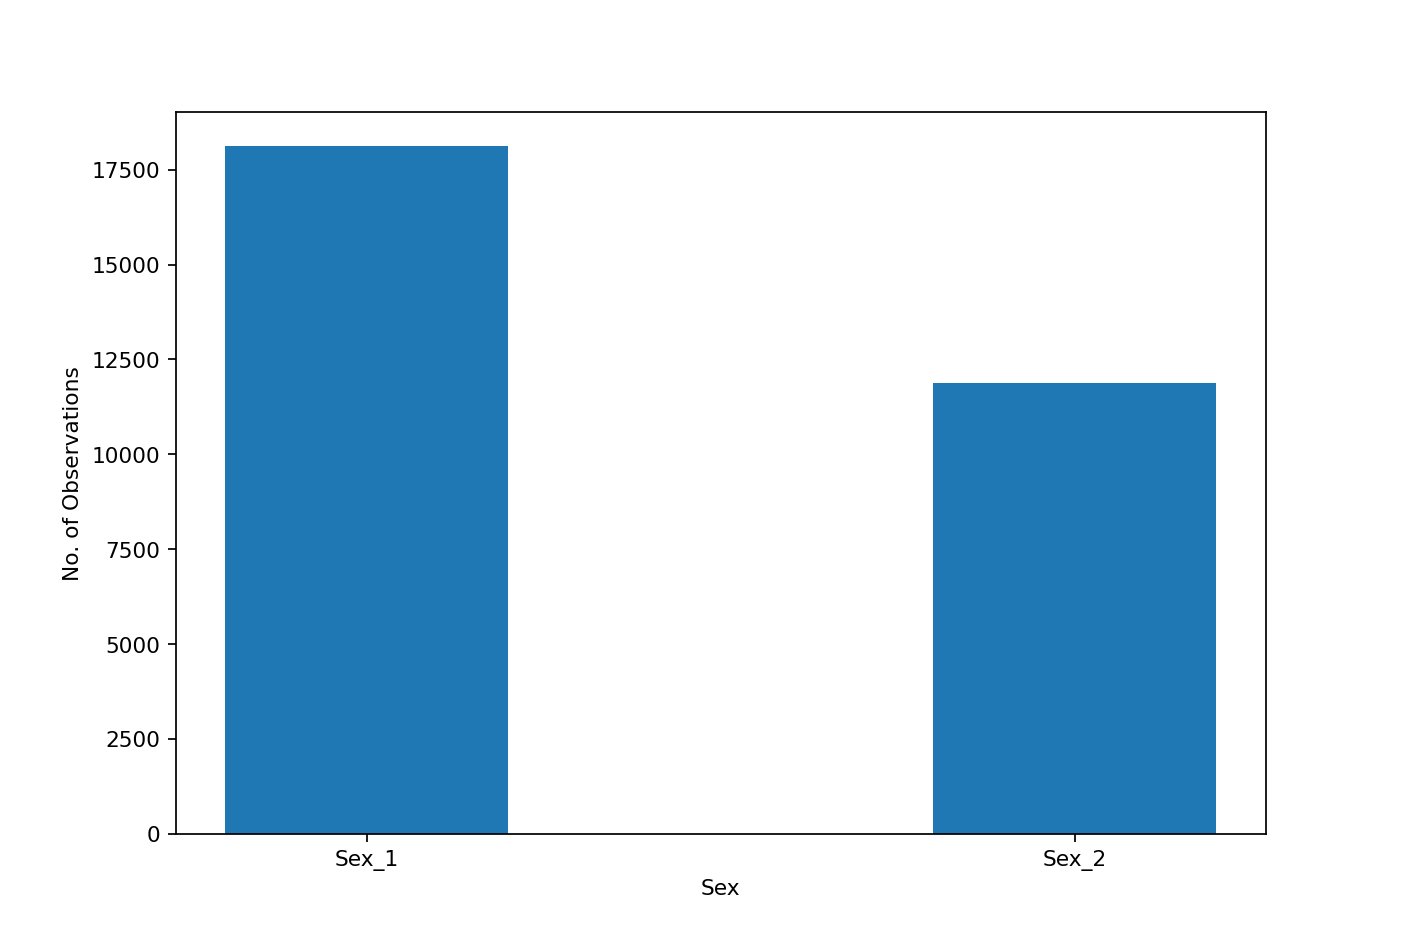

In [20]:
fig = plt.figure(figsize = (9, 6))
plt.bar(SEX_types, SEX_counts,
        width = 0.4) 
plt.xlabel("Sex")
plt.ylabel("No. of Observations")
plt.show()

### EDUCATION: In general, EDUCATION looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.¶

In [21]:
df["EDUCATION"] = df["EDUCATION"].astype('category')
df["EDUCATION"].dtype

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6'], ordered=False, categories_dtype=object)

In [22]:
df["EDUCATION"].describe()

count     30000
unique        7
top           2
freq      14030
Name: EDUCATION, dtype: object

In [23]:
EDUCATION_counts = df["EDUCATION"].value_counts()
EDUCATION_types = ['Ed_0','Ed_1','Ed_2','Ed_3','Ed_4','Ed_5','Ed_6']

<IPython.core.display.Javascript object>


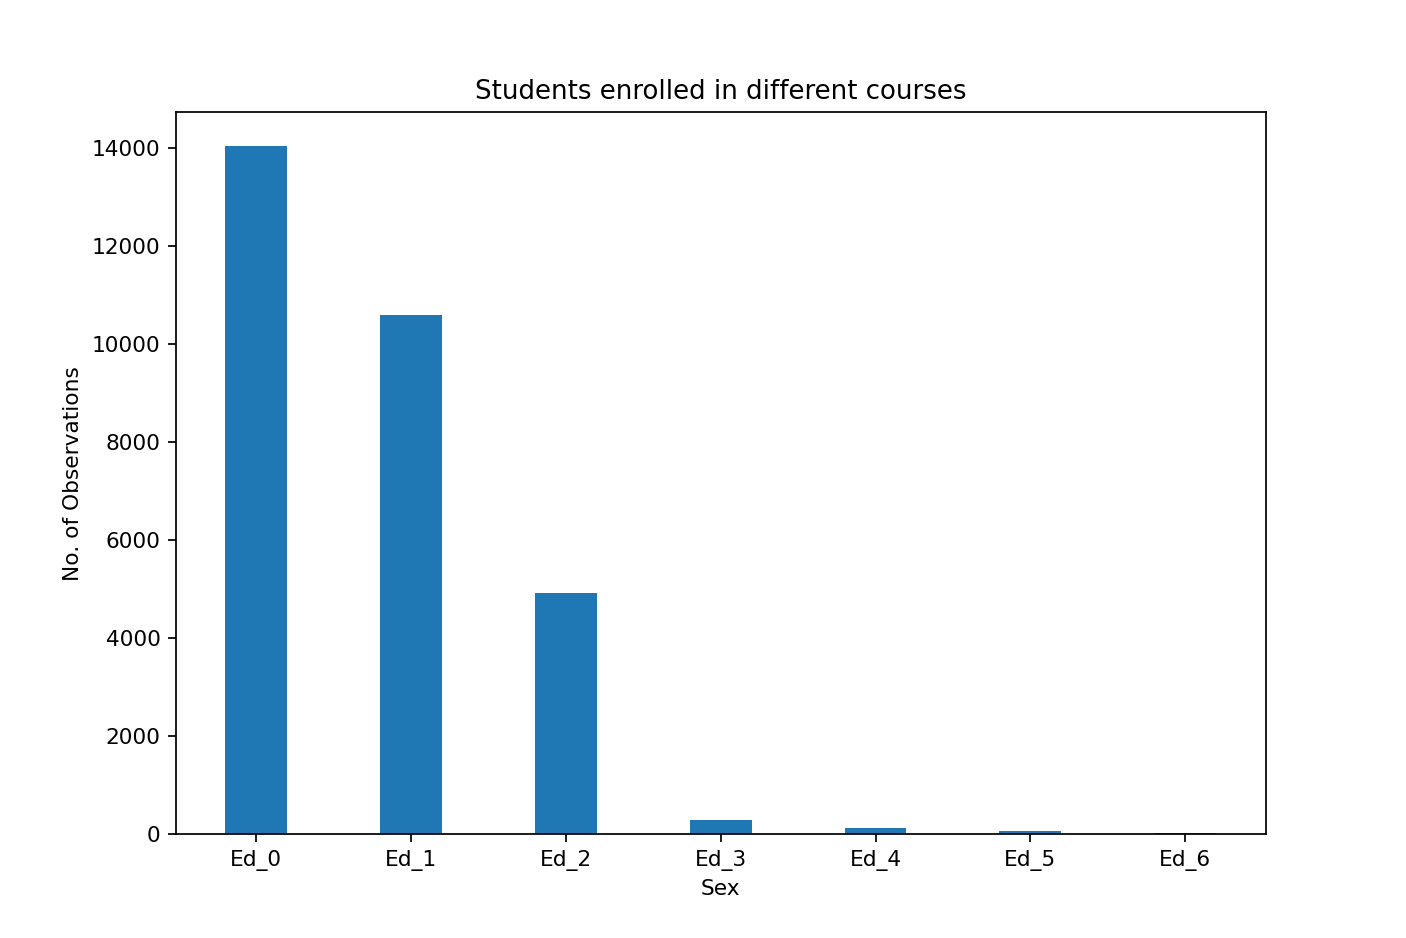

In [24]:
fig = plt.figure(figsize = (9, 6))
plt.bar(EDUCATION_types, EDUCATION_counts,
        width = 0.4) 
plt.xlabel("Sex")
plt.ylabel("No. of Observations")
plt.title("Students enrolled in different courses")
plt.show()

### MARRIAGE: In general, MARRIAGE looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.¶

In [25]:
df["MARRIAGE"] = df["MARRIAGE"].astype('category')
df["MARRIAGE"].dtype

CategoricalDtype(categories=['0', '1', '2', '3'], ordered=False, categories_dtype=object)

In [26]:
df["MARRIAGE"].describe()

count     30000
unique        4
top           2
freq      15964
Name: MARRIAGE, dtype: object

In [27]:
MARRIAGE_counts = df["MARRIAGE"].value_counts()
MARRIAGE_types = ['Married_0','Married_1','Married_2','Married_3']

<IPython.core.display.Javascript object>


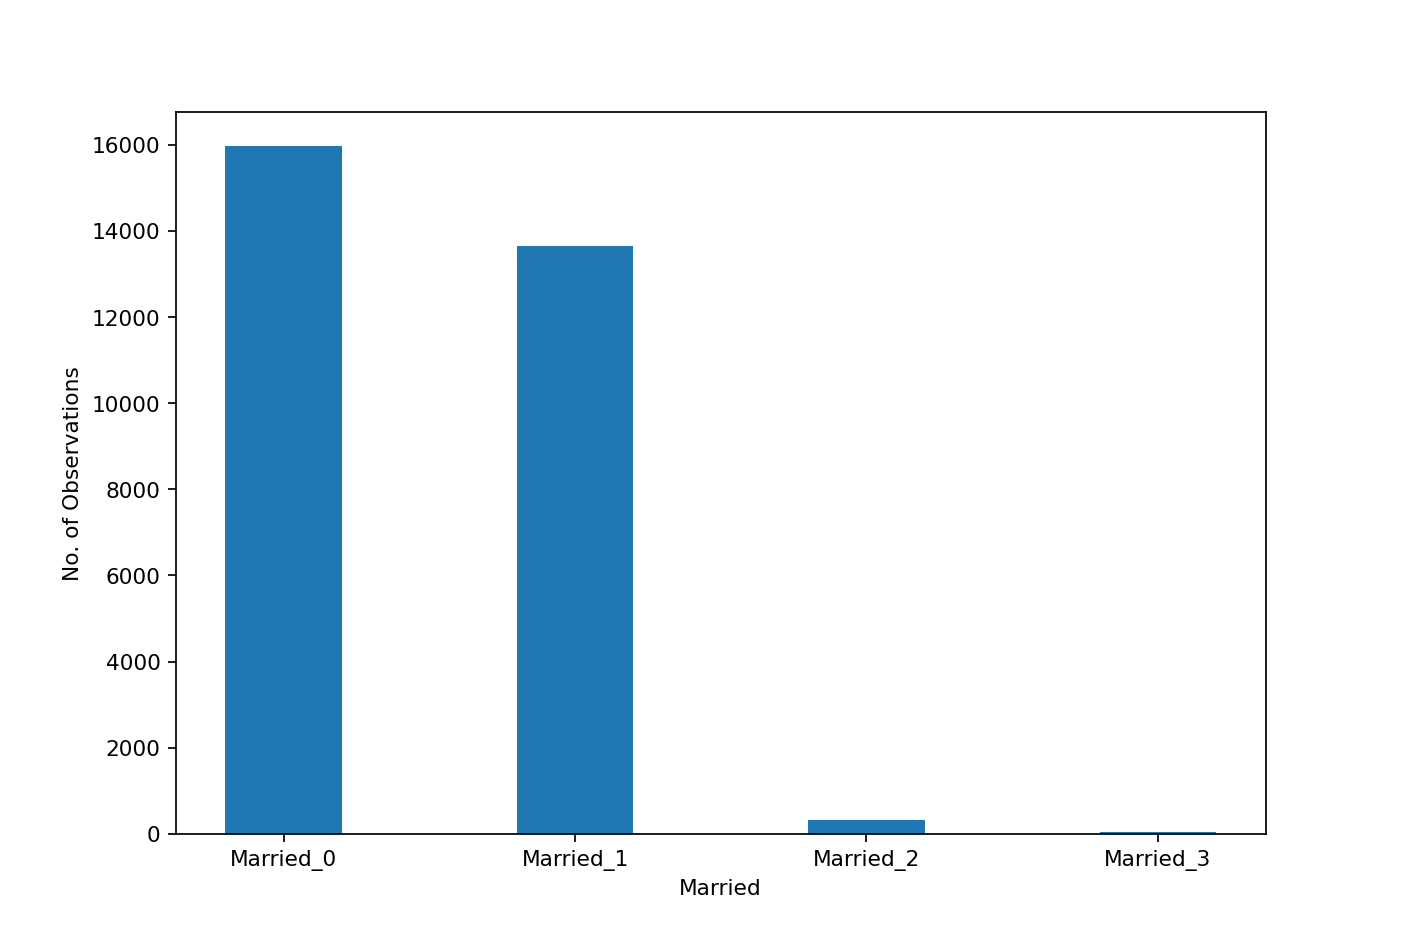

In [28]:
fig = plt.figure(figsize = (9, 6))
plt.bar(MARRIAGE_types, MARRIAGE_counts,
        width = 0.4) 
plt.xlabel("Married")
plt.ylabel("No. of Observations")
plt.show()

### AGE: In general, AGE looks like is has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [29]:
df["AGE"] = pd.to_numeric(df["AGE"], errors='coerce')
df["AGE"].dtype

dtype('int64')

In [30]:
df["AGE"].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

<IPython.core.display.Javascript object>


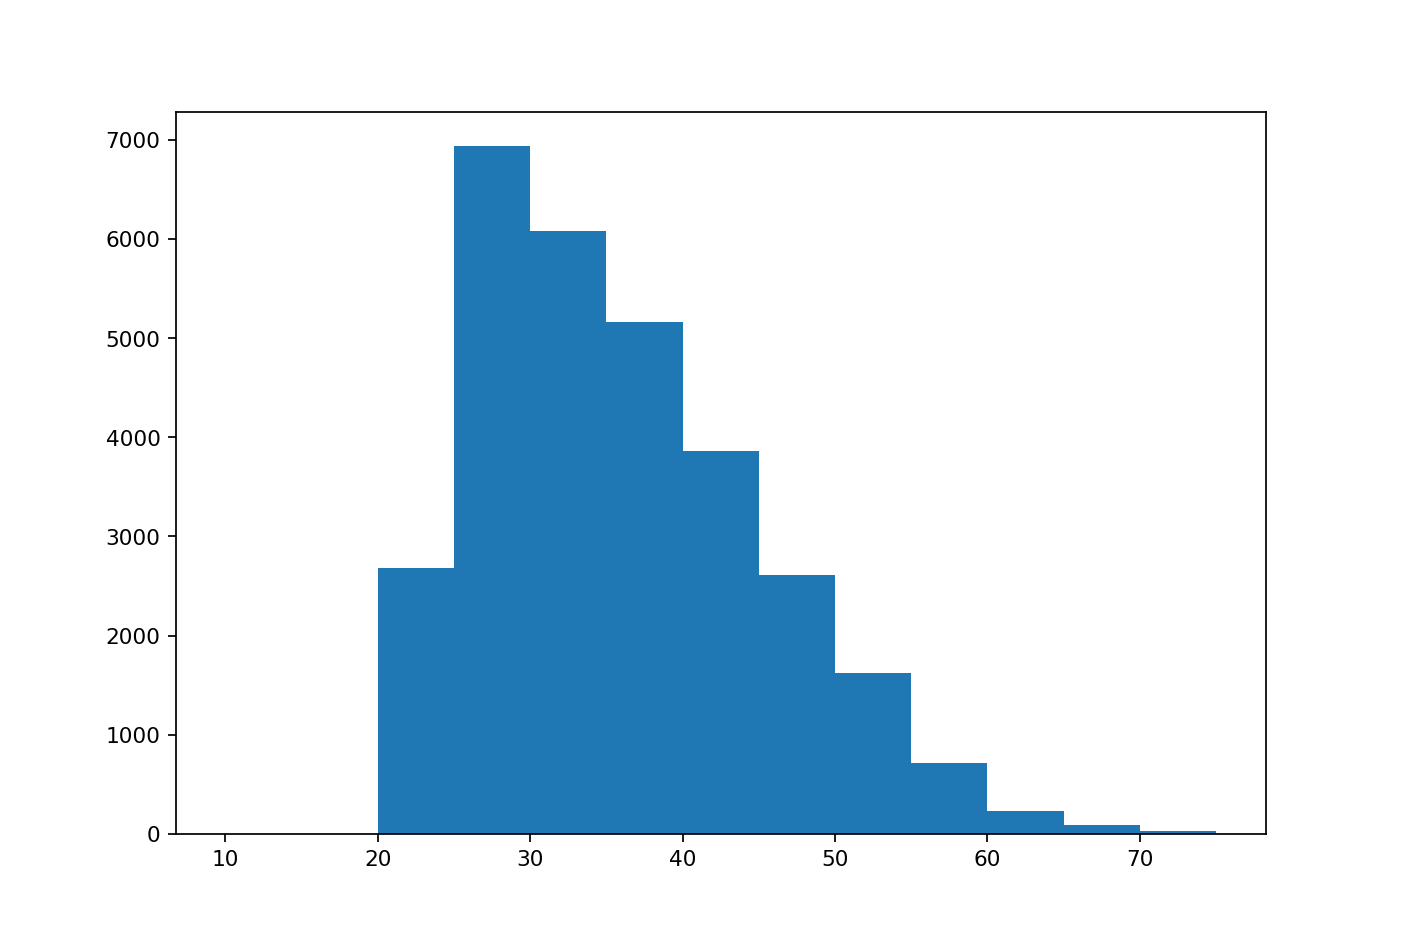

In [31]:
bins_2 = list(range(10,80,5))
plt.figure(figsize=(9,6))
plt.hist(df["AGE"],
        bins = bins_2)
plt.show()

### PAY_0: In general, PAY_0 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [32]:
df["PAY_0"] = df["PAY_0"].astype('int')
df["PAY_0"].dtype

dtype('int32')

In [33]:
df["PAY_0"].describe()

count    30000.000000
mean        -0.016700
std          1.123802
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_0, dtype: float64

In [34]:
PAY_0_counts = df["PAY_0"].value_counts().sort_index()
PAY_0_types = df["PAY_0"].value_counts().sort_index().index
PAY_0_counts

PAY_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64

<IPython.core.display.Javascript object>


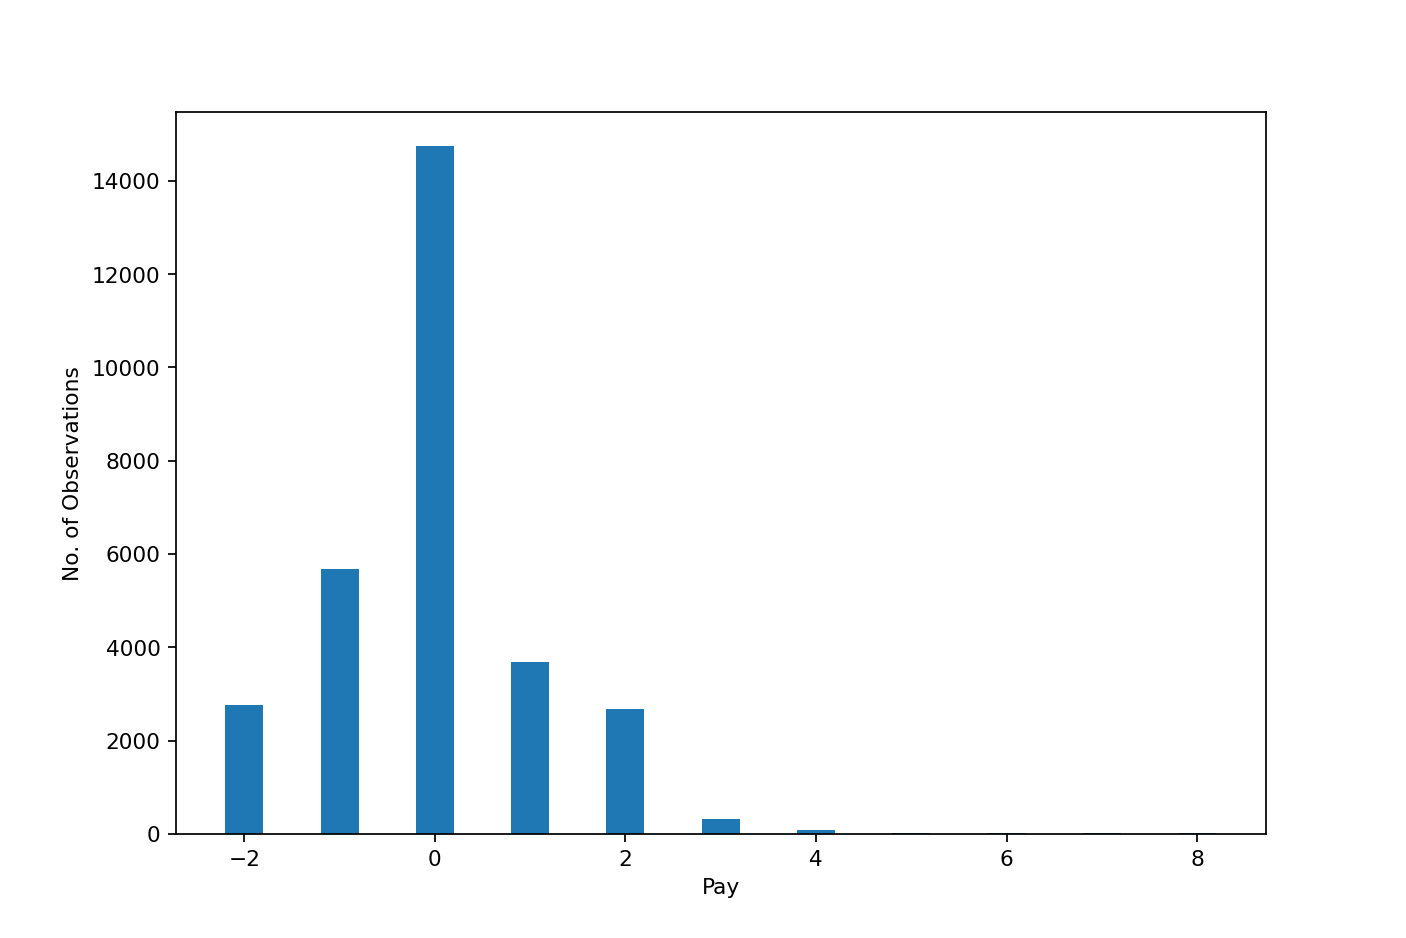

In [35]:
plt.figure(figsize = (9, 6))
plt.bar(PAY_0_types, PAY_0_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_2: In general, PAY_2 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [36]:
df["PAY_2"] = df["PAY_2"].astype('int')
df["PAY_2"].dtype

dtype('int32')

In [37]:
df["PAY_2"].describe()

count    30000.000000
mean        -0.133767
std          1.197186
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_2, dtype: float64

In [38]:
PAY_2_counts = df["PAY_2"].value_counts().sort_index()
PAY_2_types = df["PAY_2"].value_counts().sort_index().index
PAY_2_counts

PAY_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64

<IPython.core.display.Javascript object>


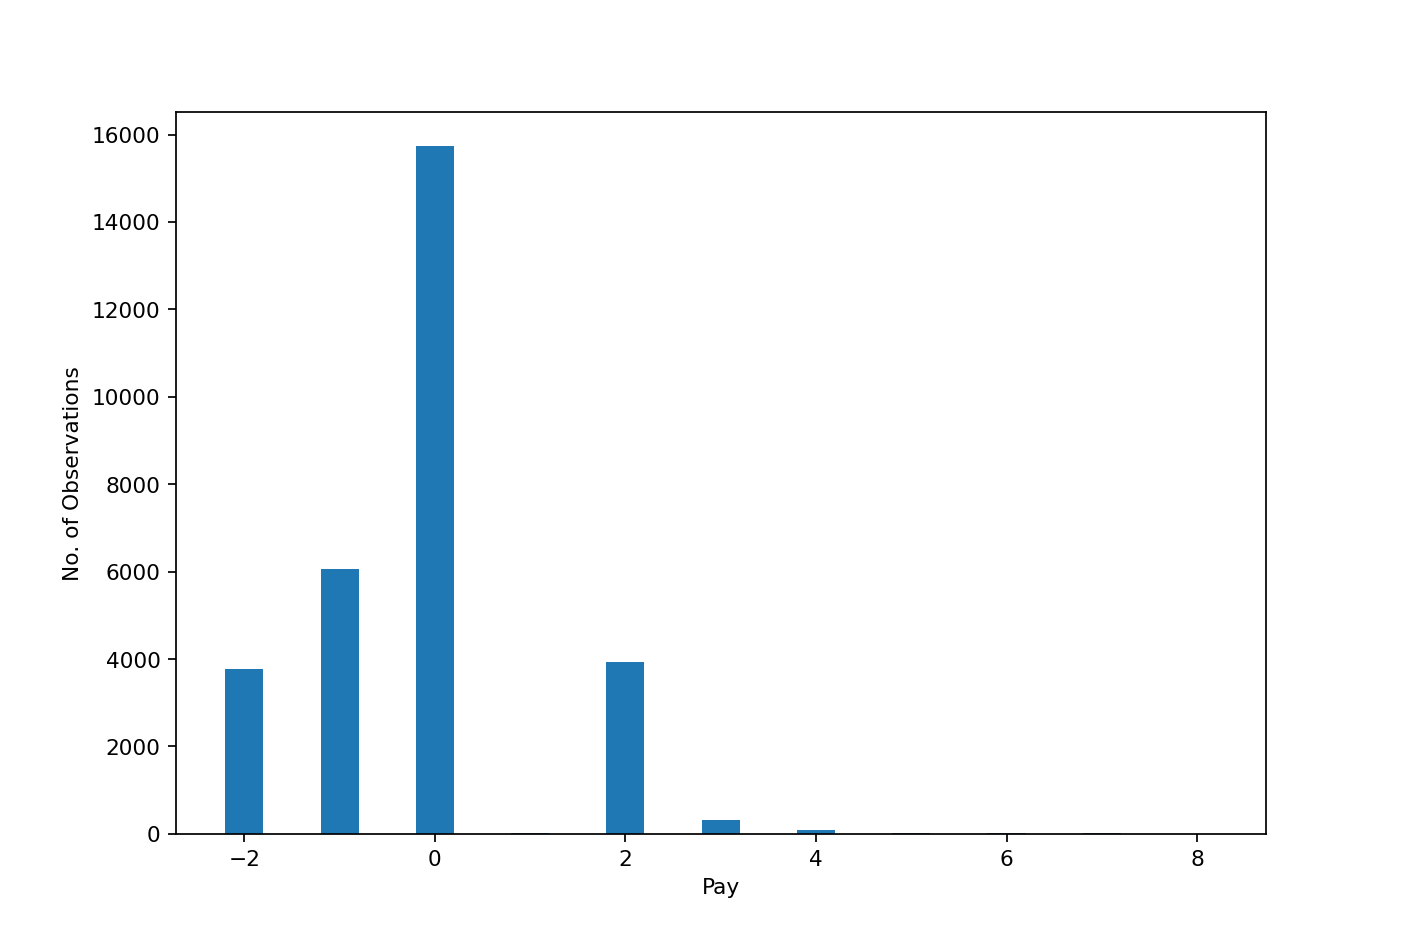

In [39]:
plt.figure(figsize = (9, 6))
plt.bar(PAY_2_types, PAY_2_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_3: In general, PAY_3 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [40]:
df["PAY_3"] = df["PAY_3"].astype('int')
df["PAY_3"].dtype

dtype('int32')

In [41]:
df["PAY_3"].describe()

count    30000.000000
mean        -0.166200
std          1.196868
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_3, dtype: float64

In [42]:
PAY_3_counts = df["PAY_3"].value_counts().sort_index()
PAY_3_types = df["PAY_3"].value_counts().sort_index().index
PAY_3_counts

PAY_3
-2     4085
-1     5938
 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64

<IPython.core.display.Javascript object>


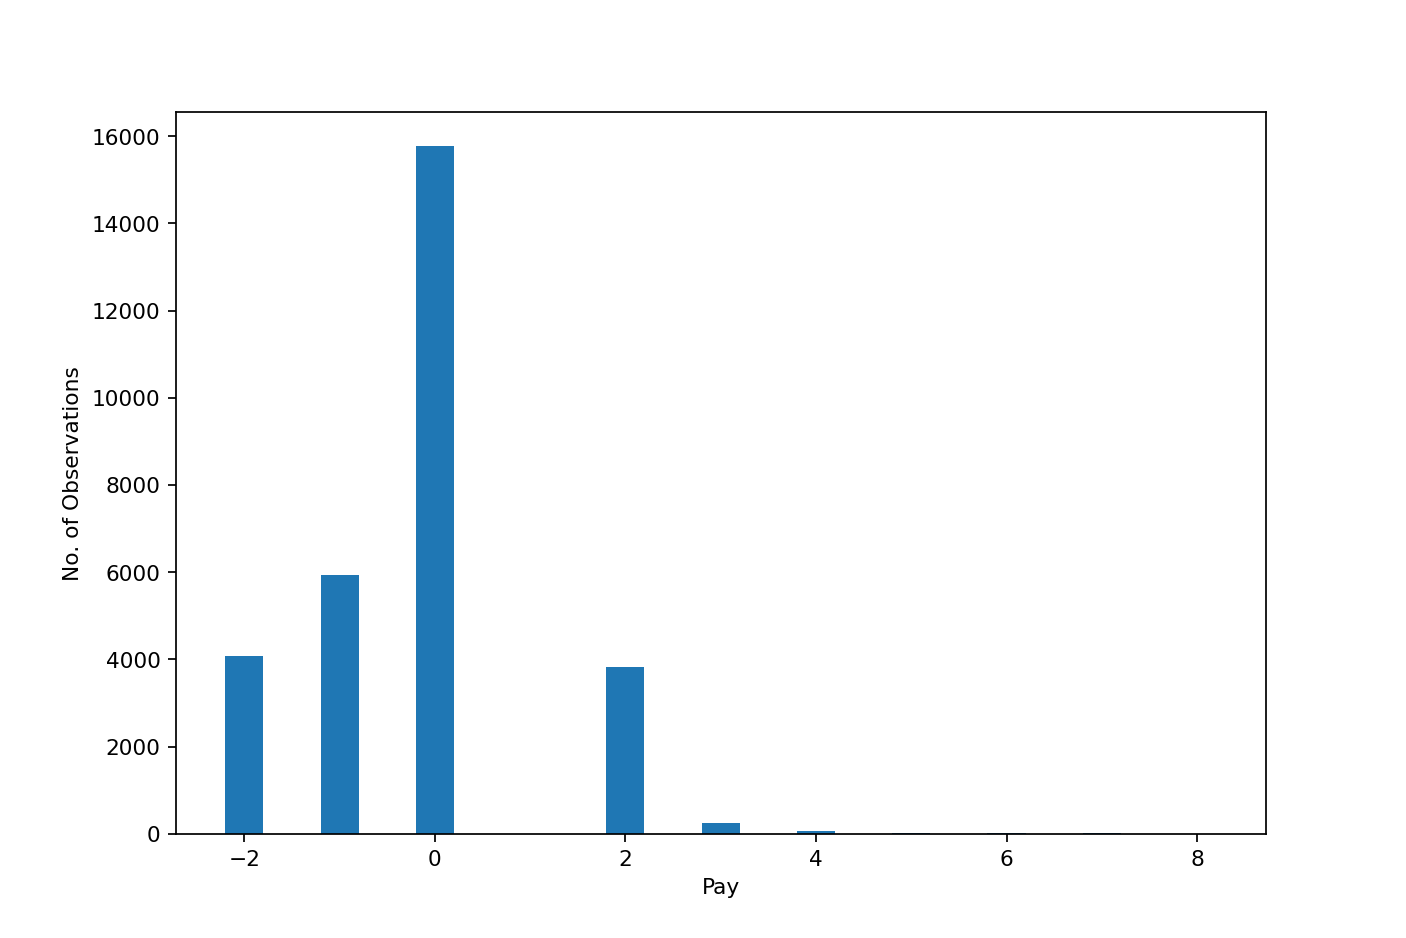

In [43]:
plt.figure(figsize = (9, 6))
plt.bar(PAY_3_types, PAY_3_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_4: In general, PAY_4 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [44]:
df["PAY_4"] = df["PAY_4"].astype('int')
df["PAY_4"].dtype

dtype('int32')

In [45]:
df["PAY_4"].describe()

count    30000.000000
mean        -0.220667
std          1.169139
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_4, dtype: float64

In [46]:
PAY_4_counts = df["PAY_4"].value_counts().sort_index()
PAY_4_types = df["PAY_4"].value_counts().sort_index().index
PAY_4_counts

PAY_4
-2     4348
-1     5687
 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64

<IPython.core.display.Javascript object>


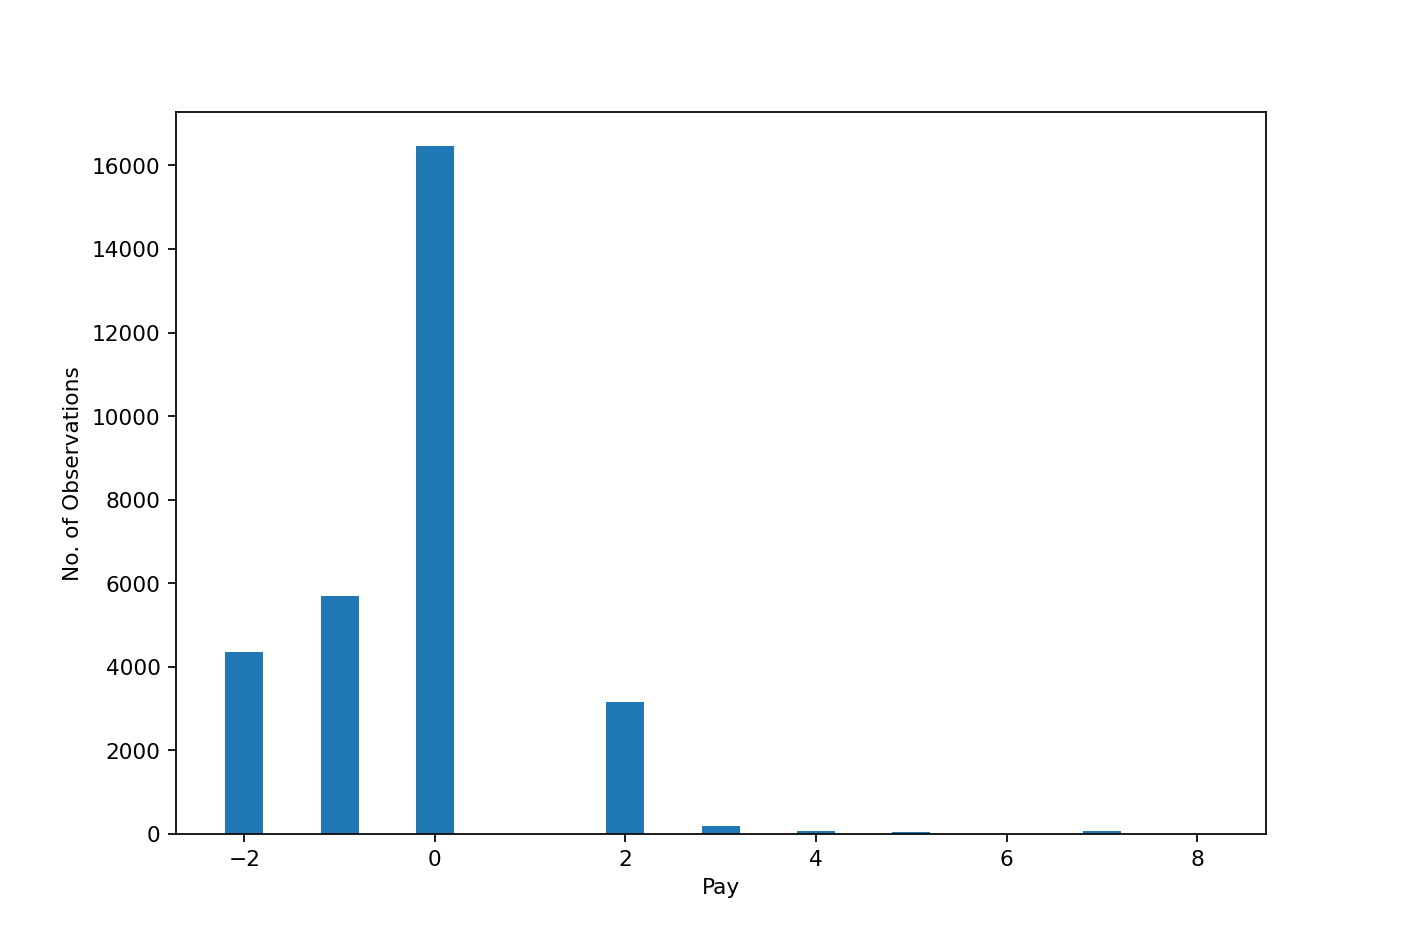

In [47]:
plt.figure(figsize = (9, 6))
plt.bar(PAY_4_types, PAY_4_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_5: In general, PAY_5 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [48]:
df["PAY_5"] = df["PAY_5"].astype('int')
df["PAY_5"].dtype

dtype('int32')

In [49]:
df["PAY_5"].describe()

count    30000.000000
mean        -0.266200
std          1.133187
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_5, dtype: float64

In [50]:
PAY_5_counts = df["PAY_5"].value_counts().sort_index()
PAY_5_types = df["PAY_5"].value_counts().sort_index().index
PAY_5_counts

PAY_5
-2     4546
-1     5539
 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64

<IPython.core.display.Javascript object>


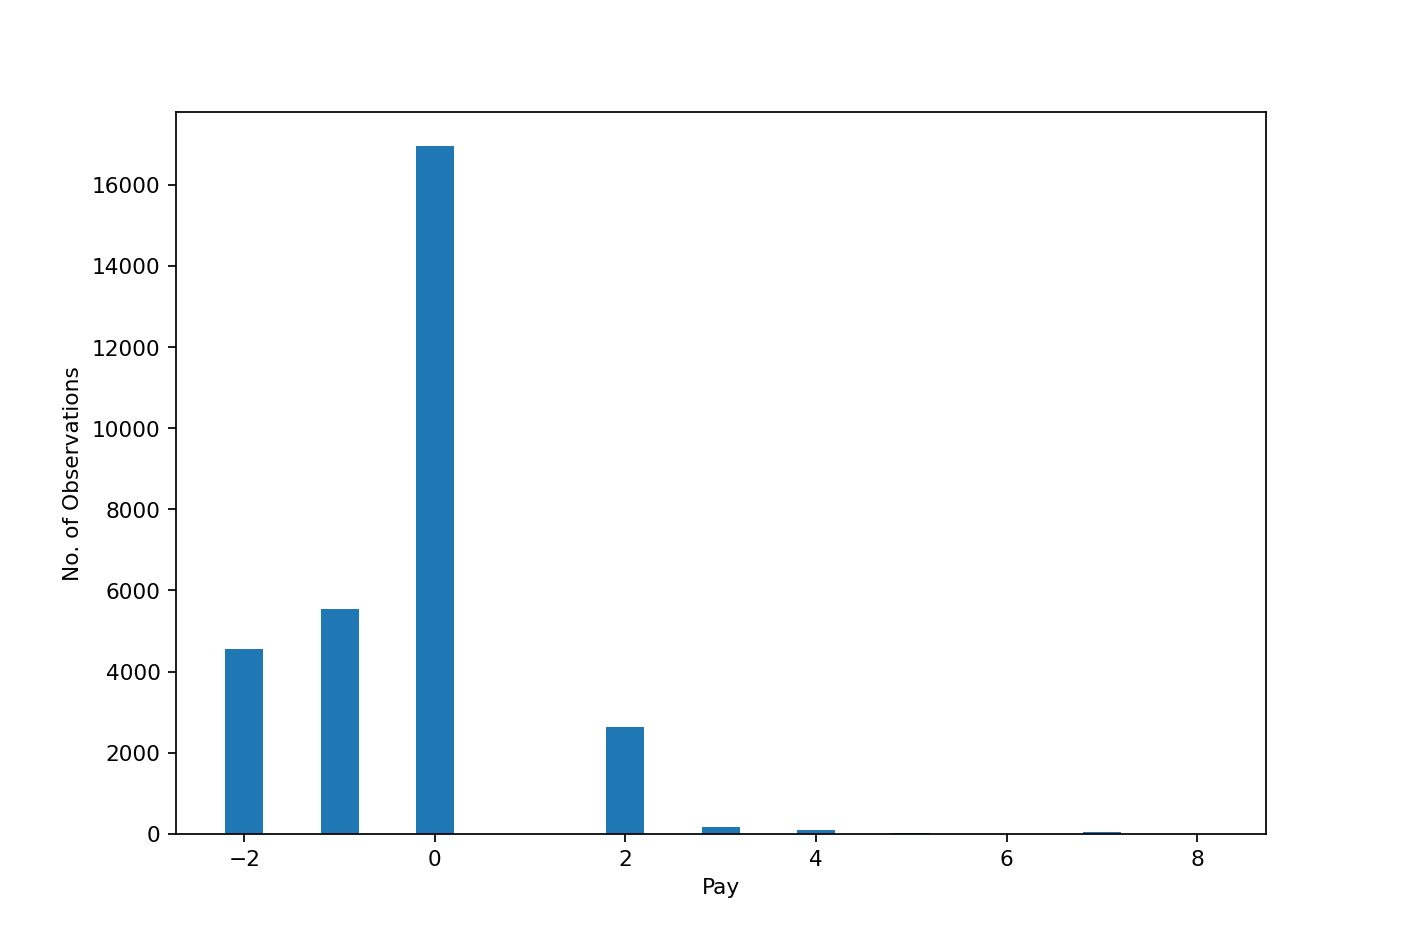

In [51]:
plt.figure(figsize = (9, 6))
plt.bar(PAY_5_types, PAY_5_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_6: In general, PAY_6 looks like it has reasonable-looking values with no obvious missing, erroneous or outlier values.

In [52]:
df["PAY_6"] = df["PAY_6"].astype('int')
df["PAY_6"].dtype

dtype('int32')

In [53]:
df["PAY_6"].describe()

count    30000.000000
mean        -0.291100
std          1.149988
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_6, dtype: float64

In [54]:
PAY_6_counts = df["PAY_6"].value_counts().sort_index()
PAY_6_types = df["PAY_6"].value_counts().sort_index().index
PAY_6_counts

PAY_6
-2     4895
-1     5740
 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype: int64

<IPython.core.display.Javascript object>


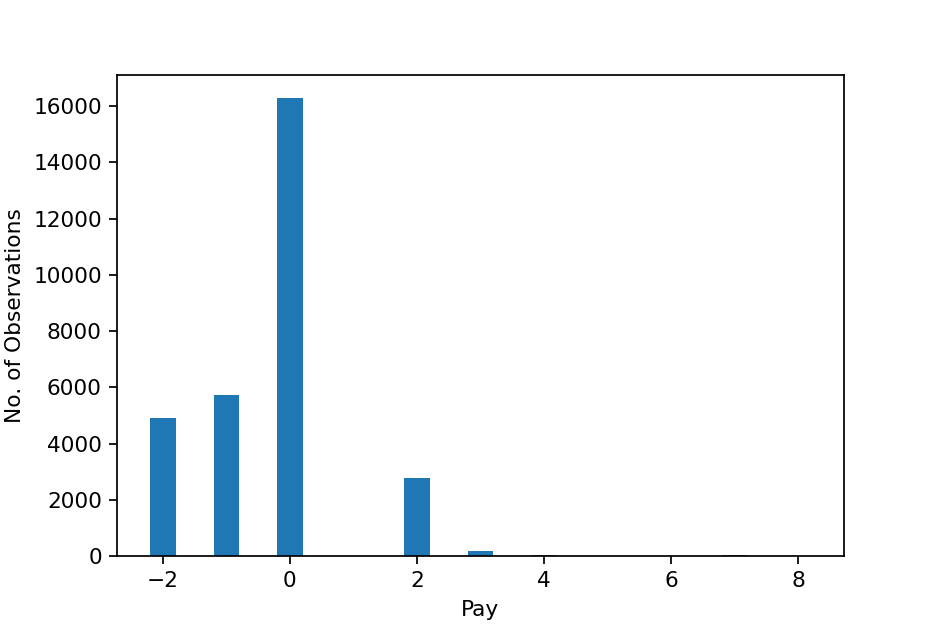

In [55]:
plt.figure(figsize = (6, 4))
plt.bar(PAY_6_types, PAY_6_counts,
        width = 0.4) 
plt.xlabel("Pay")
plt.ylabel("No. of Observations")
plt.show()

### PAY_1: Attempting to reproduce the missing PAY_1 column as the mean of PAY_0 and PAY_2.

#### But first I'll convert the other pay varaibles to floats

In [56]:
df = df.astype({'PAY_0': 'float','PAY_2': 'float', 'PAY_3': 'float', 'PAY_4': 'float', 'PAY_5': 'float','PAY_6': 'float' })

In [57]:
df.insert(7,'PAY_1', df[['PAY_0','PAY_2']].apply(simple_avg_fun, axis = 1))

In [58]:
df["PAY_1"].describe()

count    30000.000000
mean        -0.075233
std          1.061231
min         -2.000000
25%         -0.500000
50%          0.000000
75%          0.000000
max          7.500000
Name: PAY_1, dtype: float64

In [59]:
PAY_1_counts = df["PAY_1"].value_counts().sort_index()
PAY_1_counts

PAY_1
-2.0     2561
-1.5      193
-1.0     4641
-0.5     2302
 0.0    14876
 0.5      516
 1.0      940
 1.5     1677
 2.0     1703
 2.5      375
 3.0       62
 3.5       68
 4.0       17
 4.5       29
 5.5       12
 6.5        9
 7.5       19
Name: count, dtype: int64

### BILL_AMT1

In [60]:
df["BILL_AMT1"] = pd.to_numeric(df["BILL_AMT1"], errors='coerce')

In [61]:
df["BILL_AMT1"].describe()

count     30000.000000
mean      51223.330900
std       73635.860576
min     -165580.000000
25%        3558.750000
50%       22381.500000
75%       67091.000000
max      964511.000000
Name: BILL_AMT1, dtype: float64

In [62]:
len(df[df['BILL_AMT1'] < 0])

590

<IPython.core.display.Javascript object>


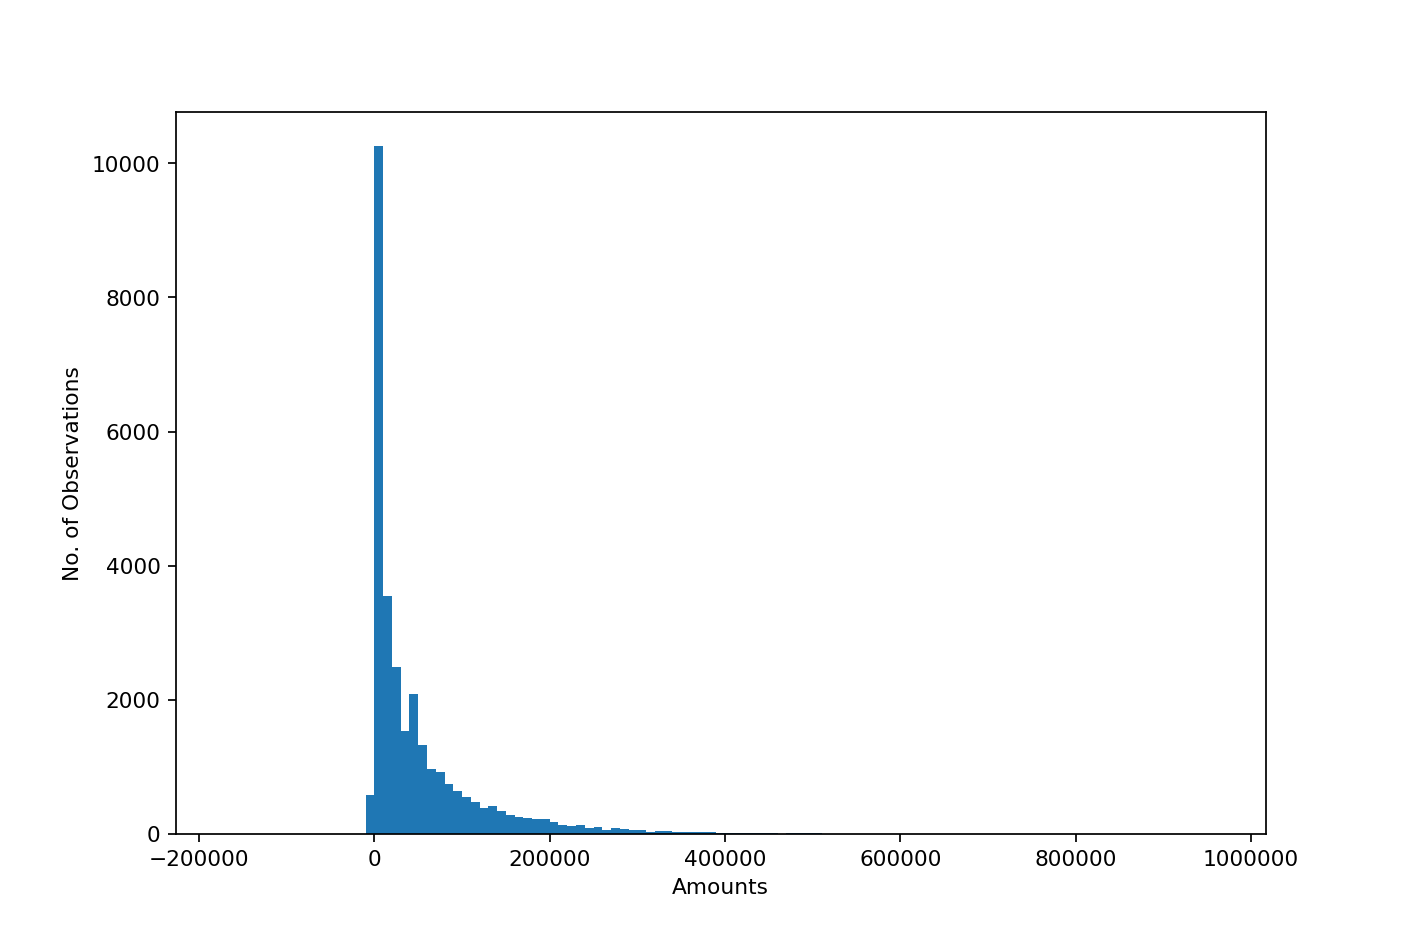

In [63]:
bin_min = rounddown((df["BILL_AMT1"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT1"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT1"],
        bins = bins_range)
plt.xlabel("Amounts")
plt.ylabel("No. of Observations")
plt.show()

### BILL_AMT2

In [64]:
df["BILL_AMT2"] = pd.to_numeric(df["BILL_AMT2"], errors='coerce')

In [65]:
df["BILL_AMT2"].describe()

count     30000.000000
mean      49179.075167
std       71173.768783
min      -69777.000000
25%        2984.750000
50%       21200.000000
75%       64006.250000
max      983931.000000
Name: BILL_AMT2, dtype: float64

In [66]:
len(df[df['BILL_AMT2'] < 0])

669

<IPython.core.display.Javascript object>


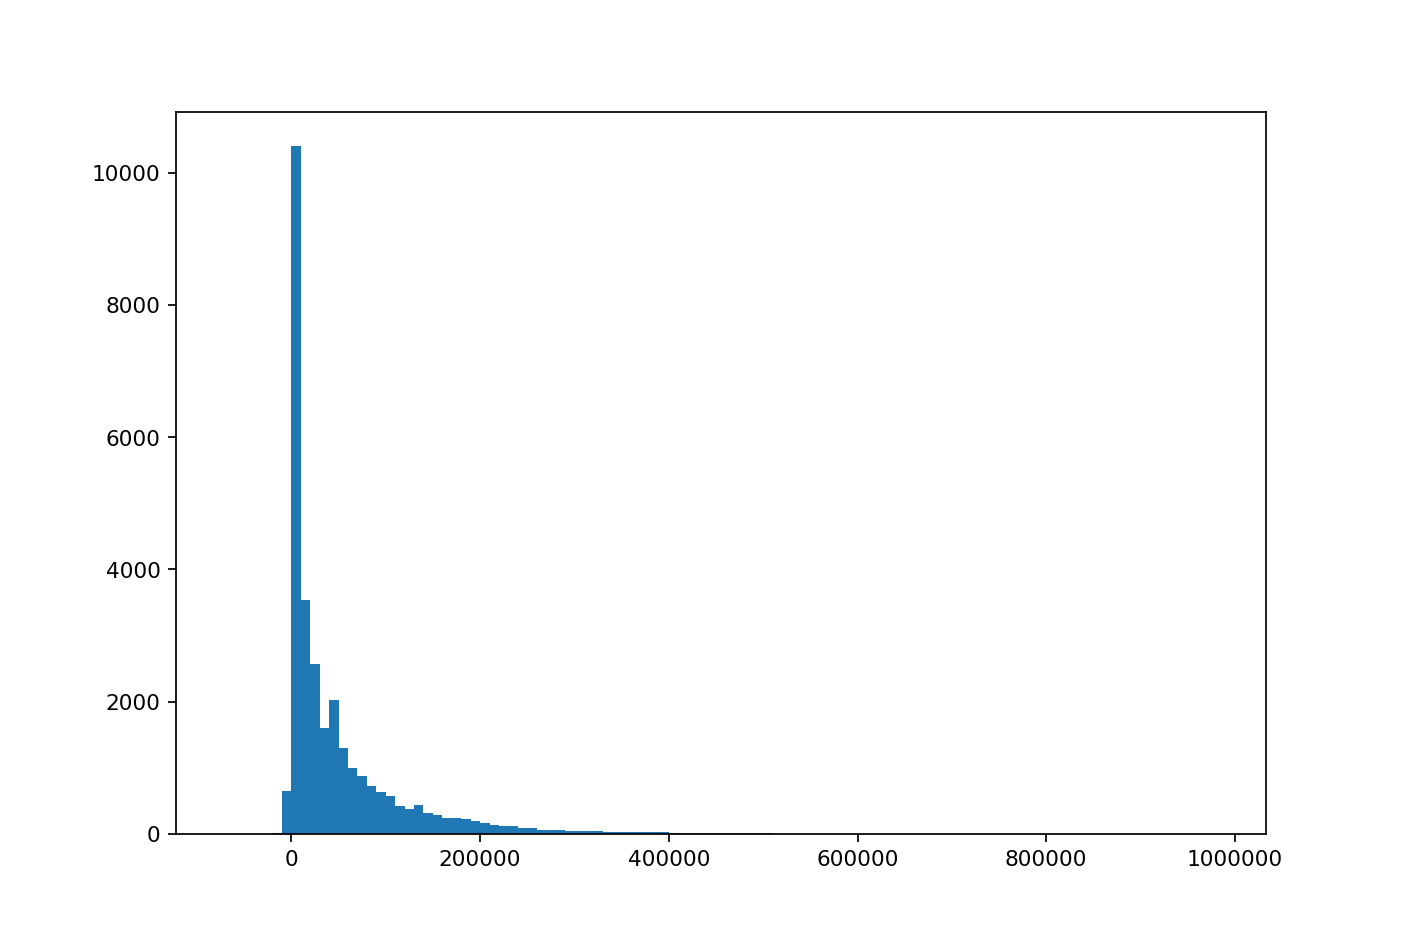

In [67]:
bin_min = rounddown((df["BILL_AMT2"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT2"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT2"],
        bins = bins_range)
plt.show()

### BILL_AMT3

In [68]:
df["BILL_AMT3"] = pd.to_numeric(df["BILL_AMT3"], errors='coerce')

In [69]:
df["BILL_AMT3"].describe()

count    3.000000e+04
mean     4.701315e+04
std      6.934939e+04
min     -1.572640e+05
25%      2.666250e+03
50%      2.008850e+04
75%      6.016475e+04
max      1.664089e+06
Name: BILL_AMT3, dtype: float64

In [70]:
len(df[df['BILL_AMT3'] < 0])

655

<IPython.core.display.Javascript object>


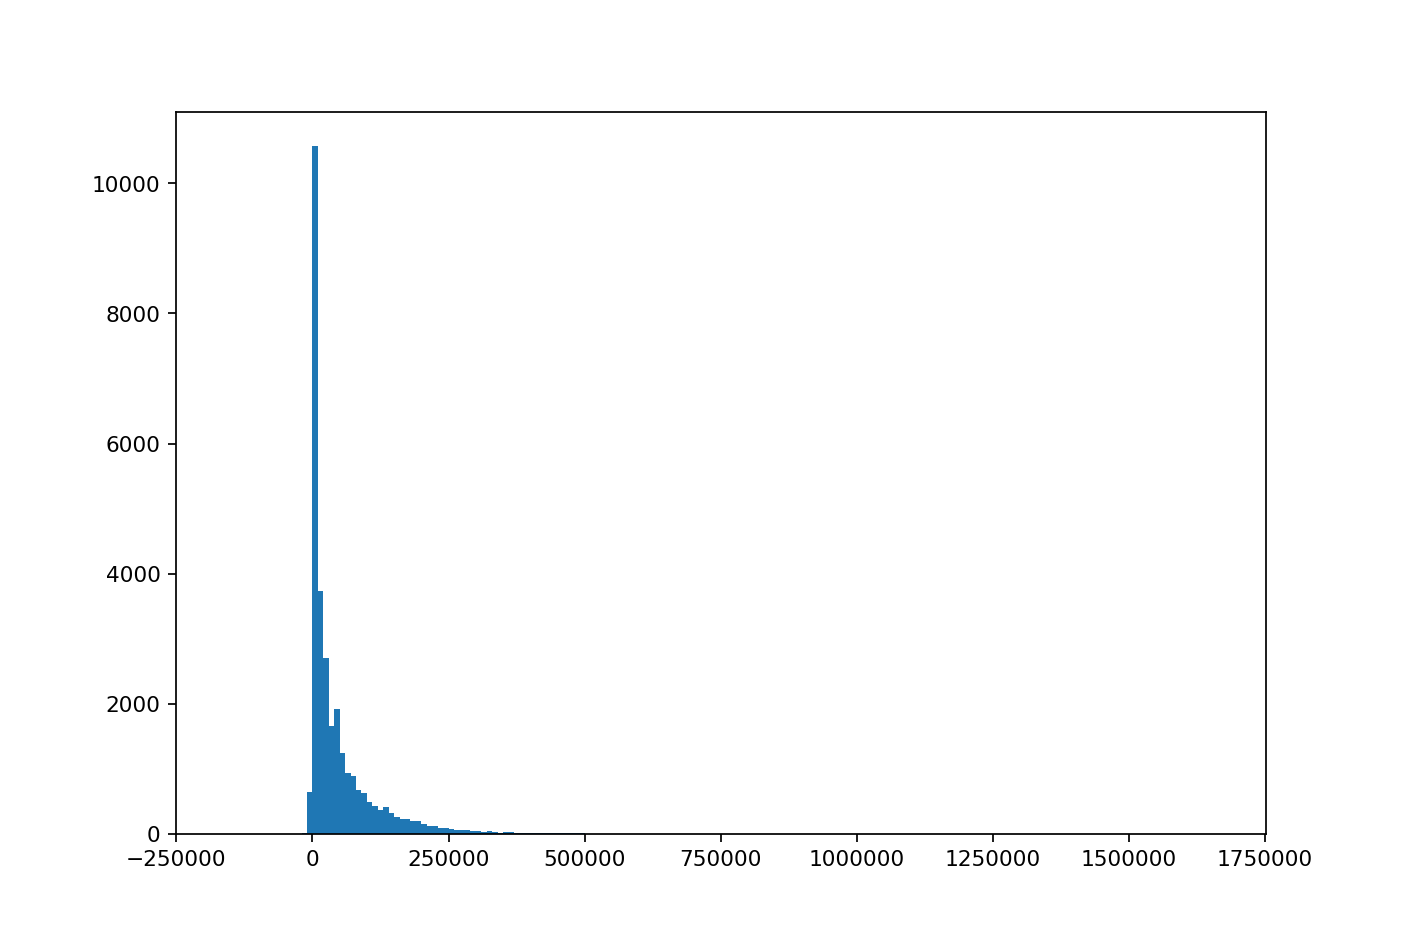

In [71]:
bin_min = rounddown((df["BILL_AMT3"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT3"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT3"],
        bins = bins_range)
plt.show()

### BILL_AMT4

In [72]:
df["BILL_AMT4"] = pd.to_numeric(df["BILL_AMT4"], errors='coerce')

In [73]:
df["BILL_AMT4"].describe()

count     30000.000000
mean      43262.948967
std       64332.856134
min     -170000.000000
25%        2326.750000
50%       19052.000000
75%       54506.000000
max      891586.000000
Name: BILL_AMT4, dtype: float64

In [74]:
len(df[df['BILL_AMT4'] < 0])

675

<IPython.core.display.Javascript object>


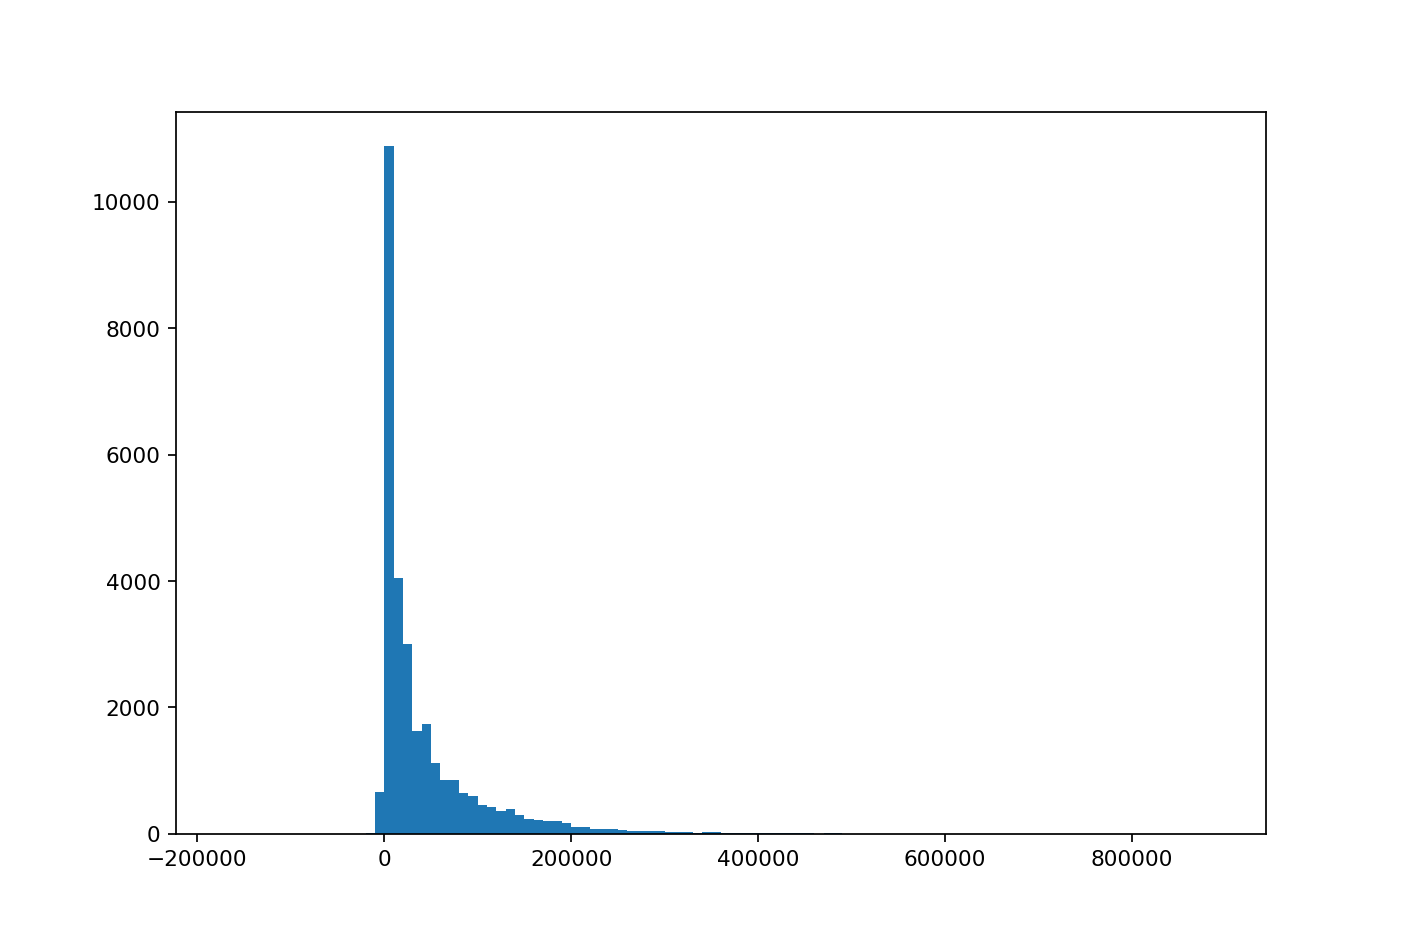

In [75]:
bin_min = rounddown((df["BILL_AMT4"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT4"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT4"],
        bins = bins_range)
plt.show()

### BILL_AMT5

In [76]:
df["BILL_AMT5"] = pd.to_numeric(df["BILL_AMT5"], errors='coerce')

In [77]:
df["BILL_AMT5"].describe()

count     30000.000000
mean      40311.400967
std       60797.155770
min      -81334.000000
25%        1763.000000
50%       18104.500000
75%       50190.500000
max      927171.000000
Name: BILL_AMT5, dtype: float64

In [78]:
len(df[df['BILL_AMT5'] < 0])

655

<IPython.core.display.Javascript object>


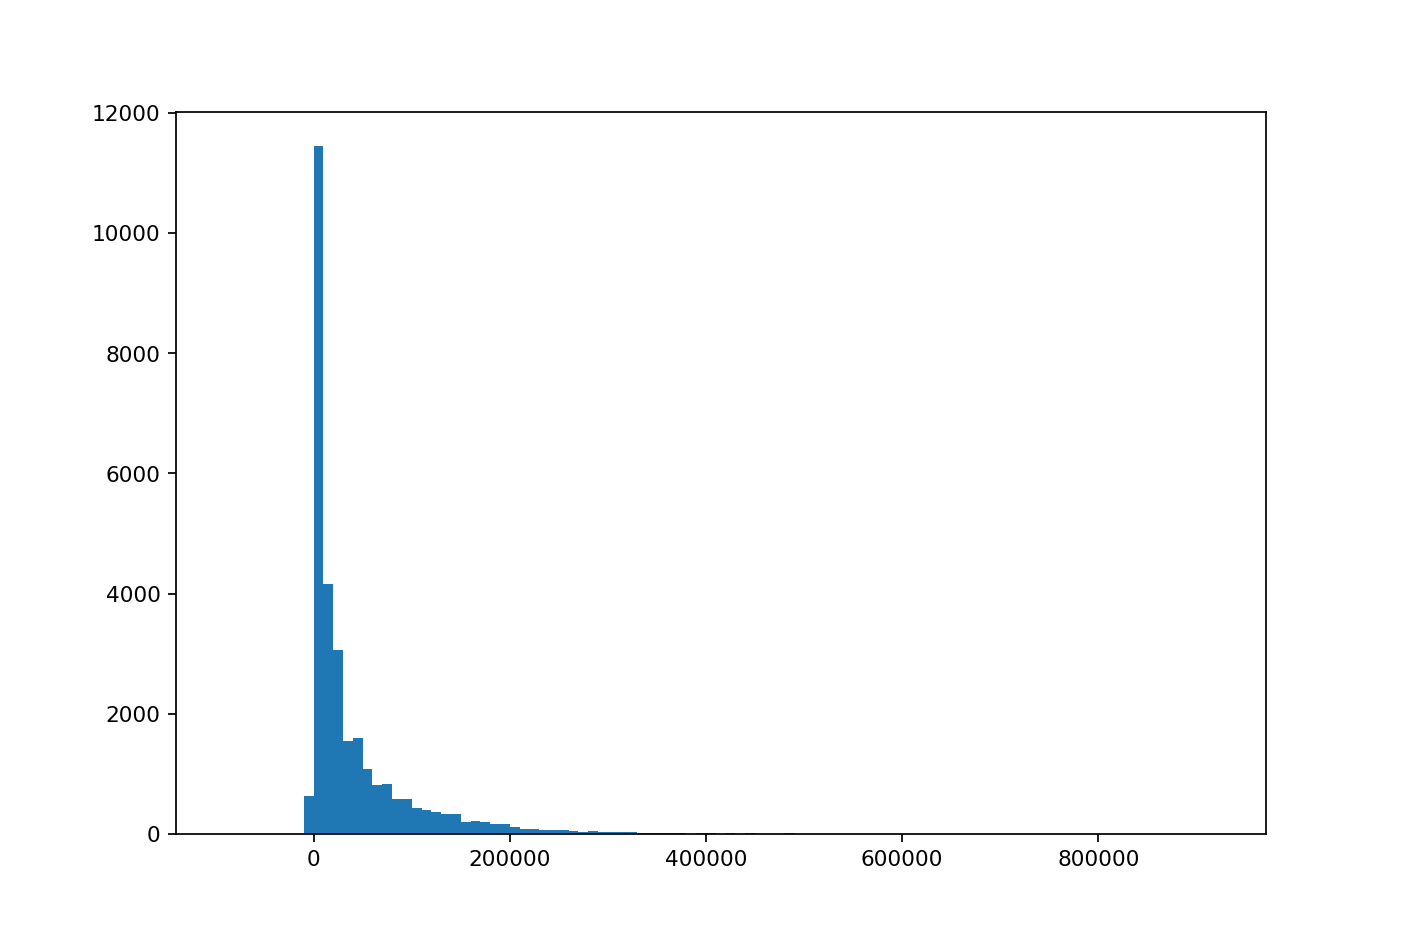

In [79]:
bin_min = rounddown((df["BILL_AMT5"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT5"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT5"],
        bins = bins_range)
plt.show()

### BILL_AMT6

In [80]:
df["BILL_AMT6"] = pd.to_numeric(df["BILL_AMT6"], errors='coerce')

In [81]:
df["BILL_AMT6"].describe()

count     30000.000000
mean      38871.760400
std       59554.107537
min     -339603.000000
25%        1256.000000
50%       17071.000000
75%       49198.250000
max      961664.000000
Name: BILL_AMT6, dtype: float64

In [82]:
len(df[df['BILL_AMT6'] < 0])

688

<IPython.core.display.Javascript object>


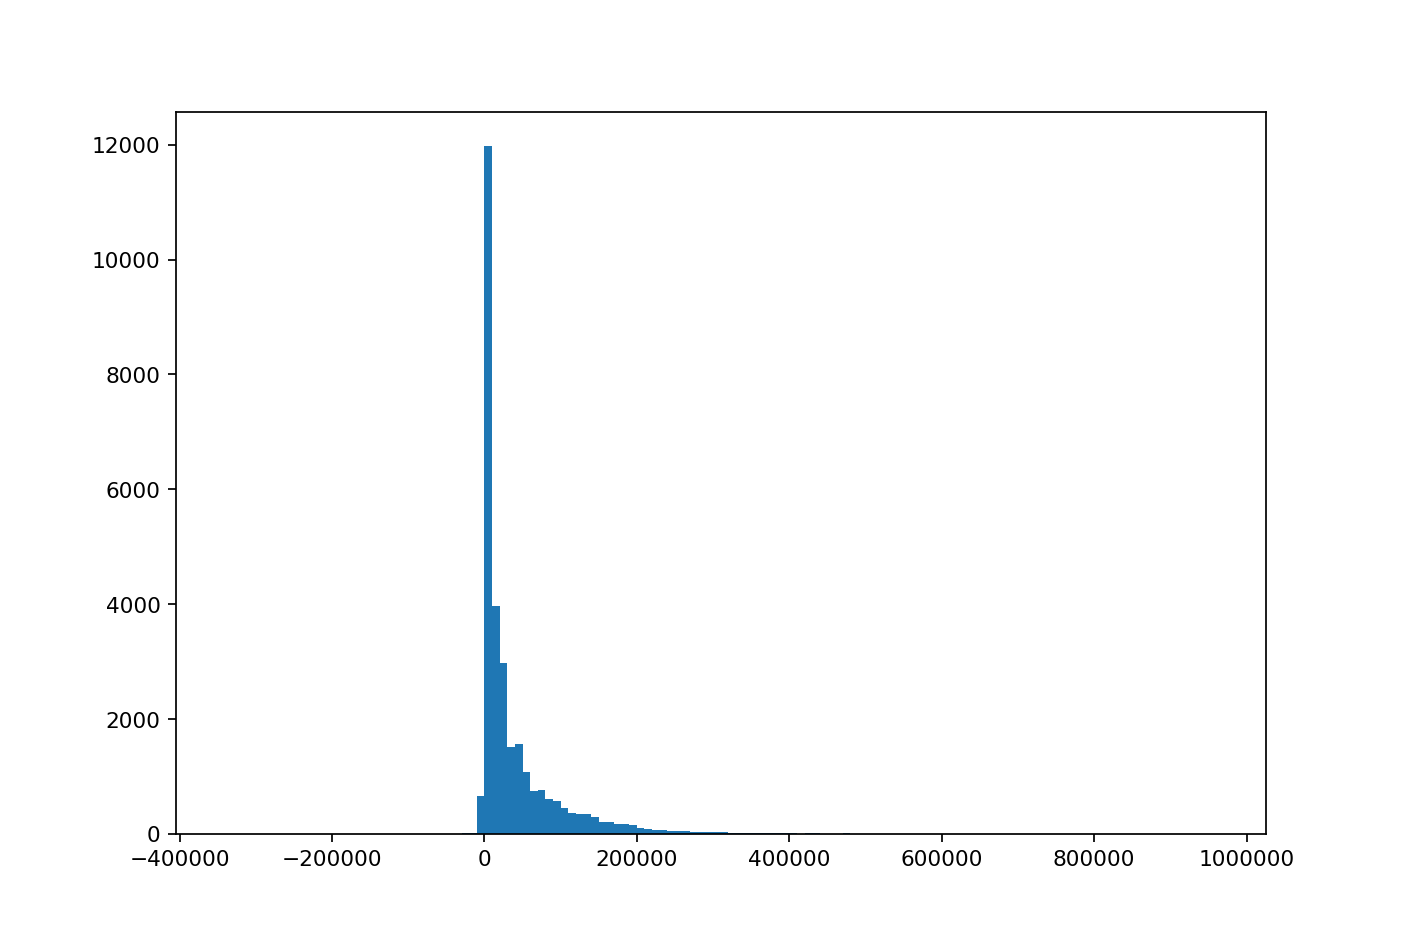

In [83]:
bin_min = rounddown((df["BILL_AMT6"].min(axis=0)),10000)
bin_max = roundup((df["BILL_AMT6"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["BILL_AMT6"],
        bins = bins_range)
plt.show()

### PAY_AMT1

In [84]:
df["PAY_AMT1"] = pd.to_numeric(df["PAY_AMT1"], errors='coerce')

In [85]:
df["PAY_AMT1"].describe()

count     30000.000000
mean       5663.580500
std       16563.280354
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5006.000000
max      873552.000000
Name: PAY_AMT1, dtype: float64

<IPython.core.display.Javascript object>


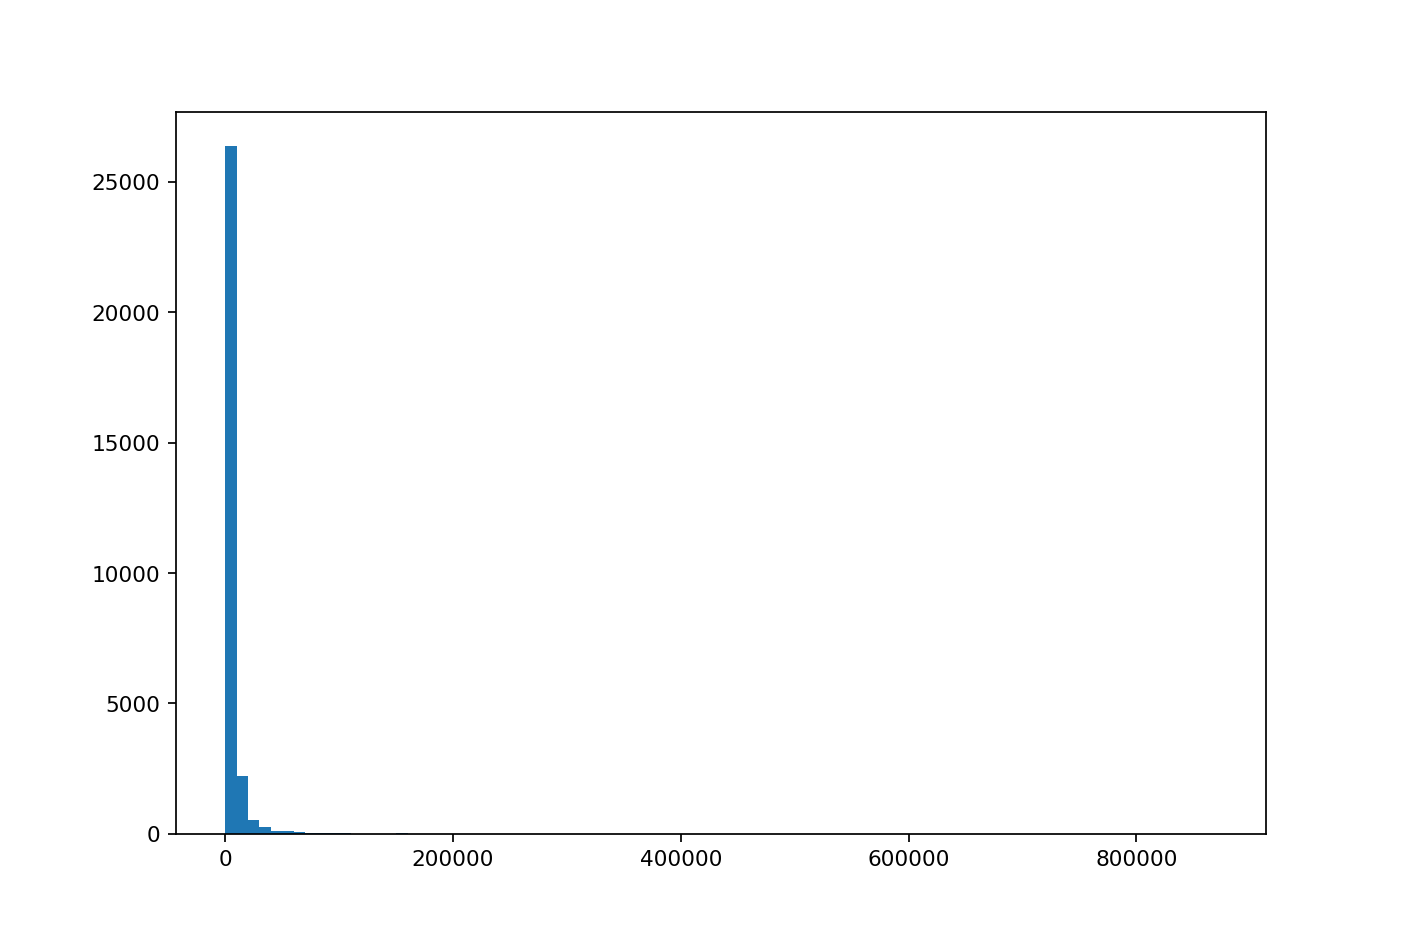

In [86]:
bin_min = rounddown((df["PAY_AMT1"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT1"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT1"],
        bins = bins_range)
plt.show()

### PAY_AMT2

In [87]:
df["PAY_AMT2"] = pd.to_numeric(df["PAY_AMT2"], errors='coerce')

In [88]:
df["PAY_AMT2"].describe()

count    3.000000e+04
mean     5.921163e+03
std      2.304087e+04
min      0.000000e+00
25%      8.330000e+02
50%      2.009000e+03
75%      5.000000e+03
max      1.684259e+06
Name: PAY_AMT2, dtype: float64

C:\Users\darre\AppData\Local\Temp\ipykernel_16532\2952029715.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,6))


<IPython.core.display.Javascript object>


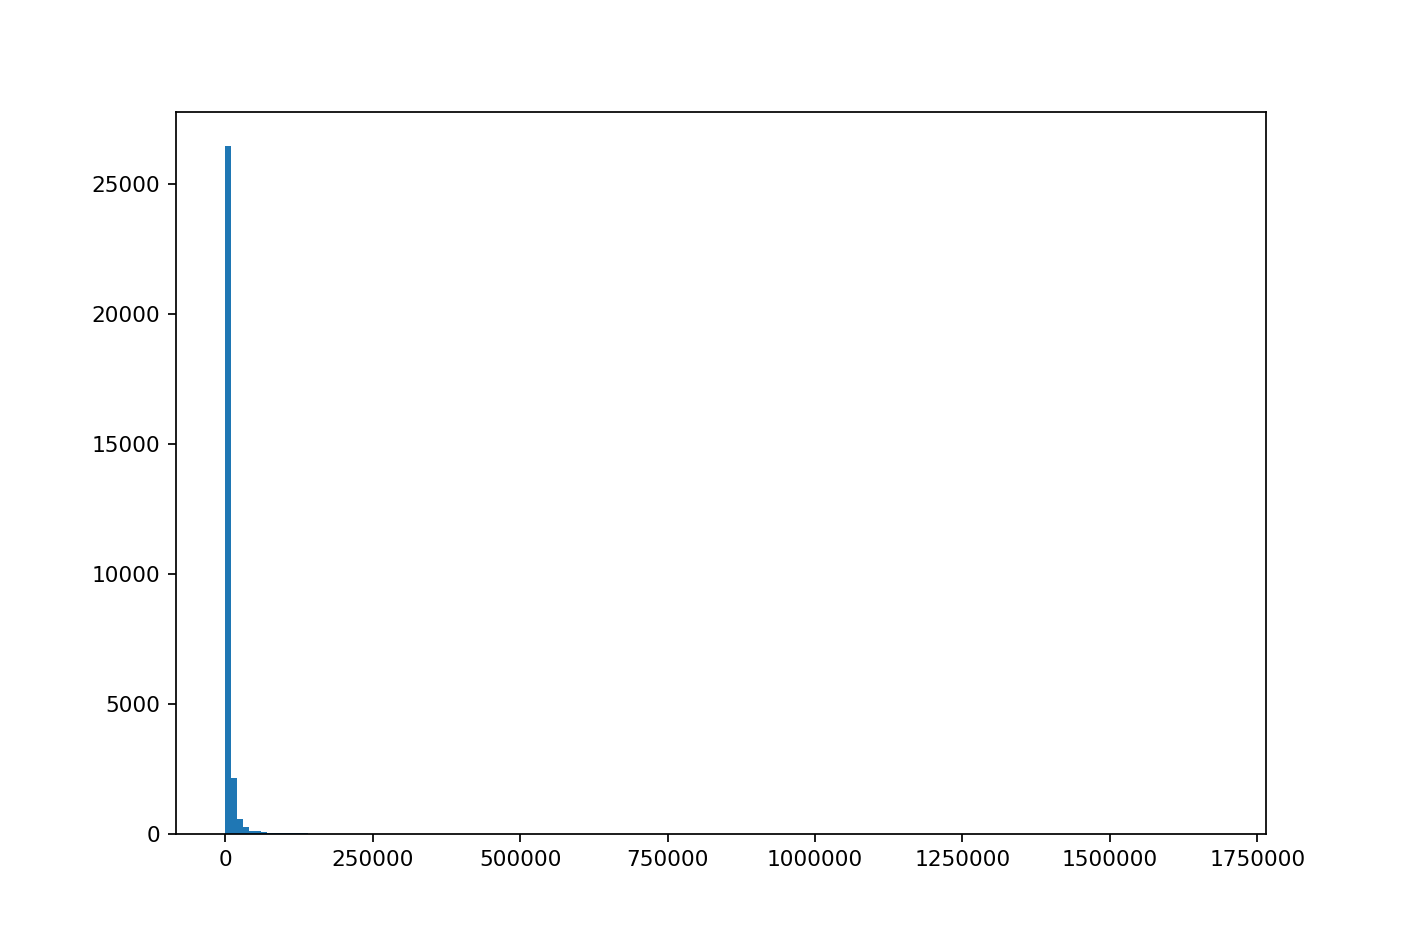

In [89]:
bin_min = rounddown((df["PAY_AMT2"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT2"].max(axis=0)),1000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT2"],
        bins = bins_range)
plt.show()

### PAY_AMT3

In [90]:
df["PAY_AMT3"] = pd.to_numeric(df["PAY_AMT3"], errors='coerce')

In [91]:
df["PAY_AMT3"].describe()

count     30000.00000
mean       5225.68150
std       17606.96147
min           0.00000
25%         390.00000
50%        1800.00000
75%        4505.00000
max      896040.00000
Name: PAY_AMT3, dtype: float64

<IPython.core.display.Javascript object>


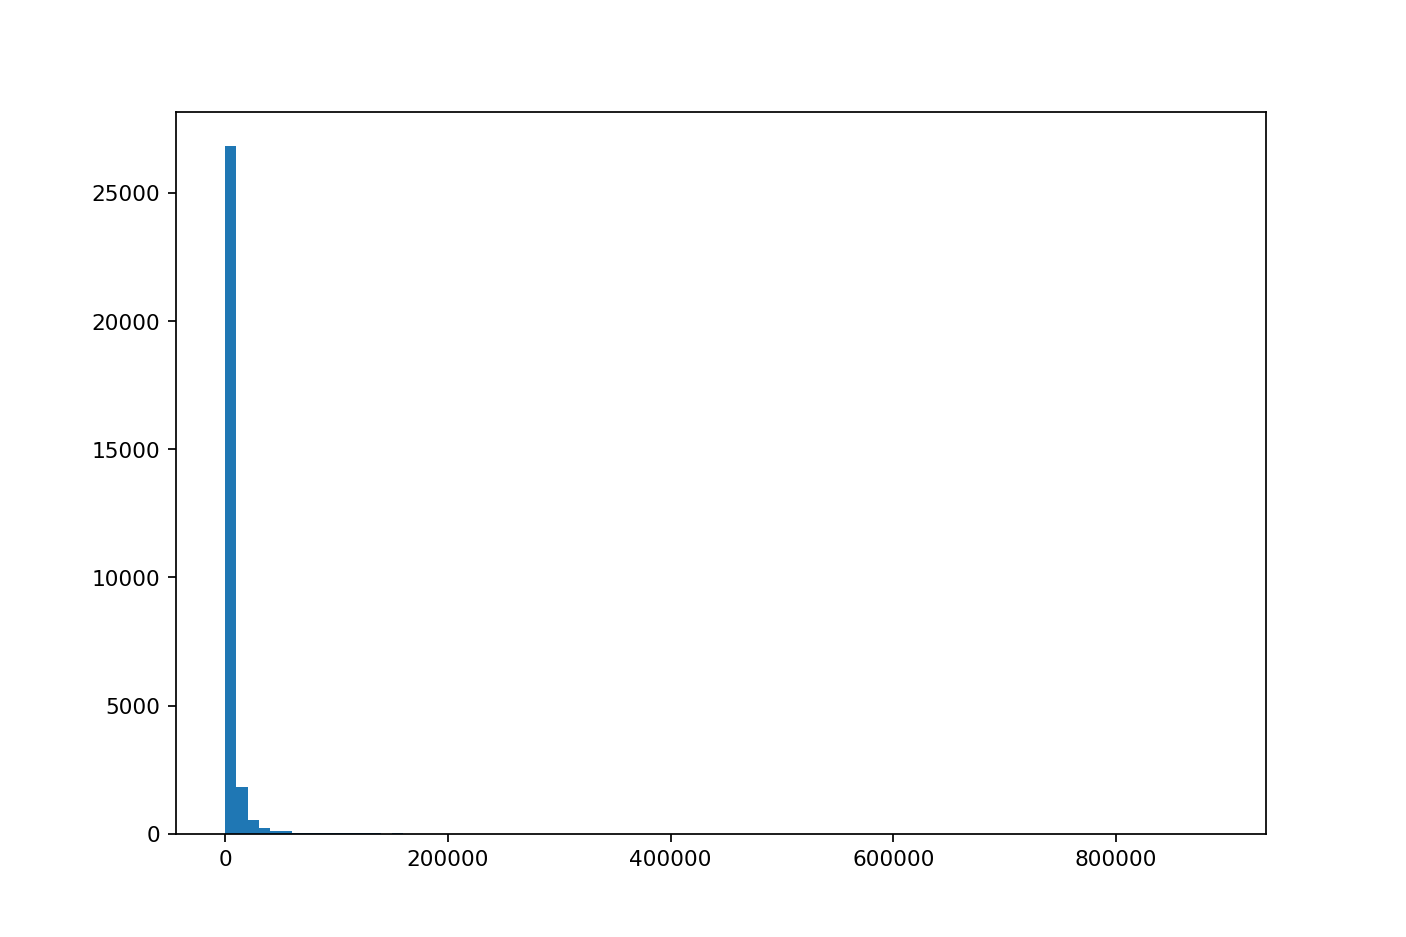

In [92]:
bin_min = rounddown((df["PAY_AMT3"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT3"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT3"],
        bins = bins_range)
plt.show()

### PAY_AMT4

In [93]:
df["PAY_AMT4"] = pd.to_numeric(df["PAY_AMT4"], errors='coerce')

In [94]:
df["PAY_AMT4"].describe()

count     30000.000000
mean       4826.076867
std       15666.159744
min           0.000000
25%         296.000000
50%        1500.000000
75%        4013.250000
max      621000.000000
Name: PAY_AMT4, dtype: float64

<IPython.core.display.Javascript object>


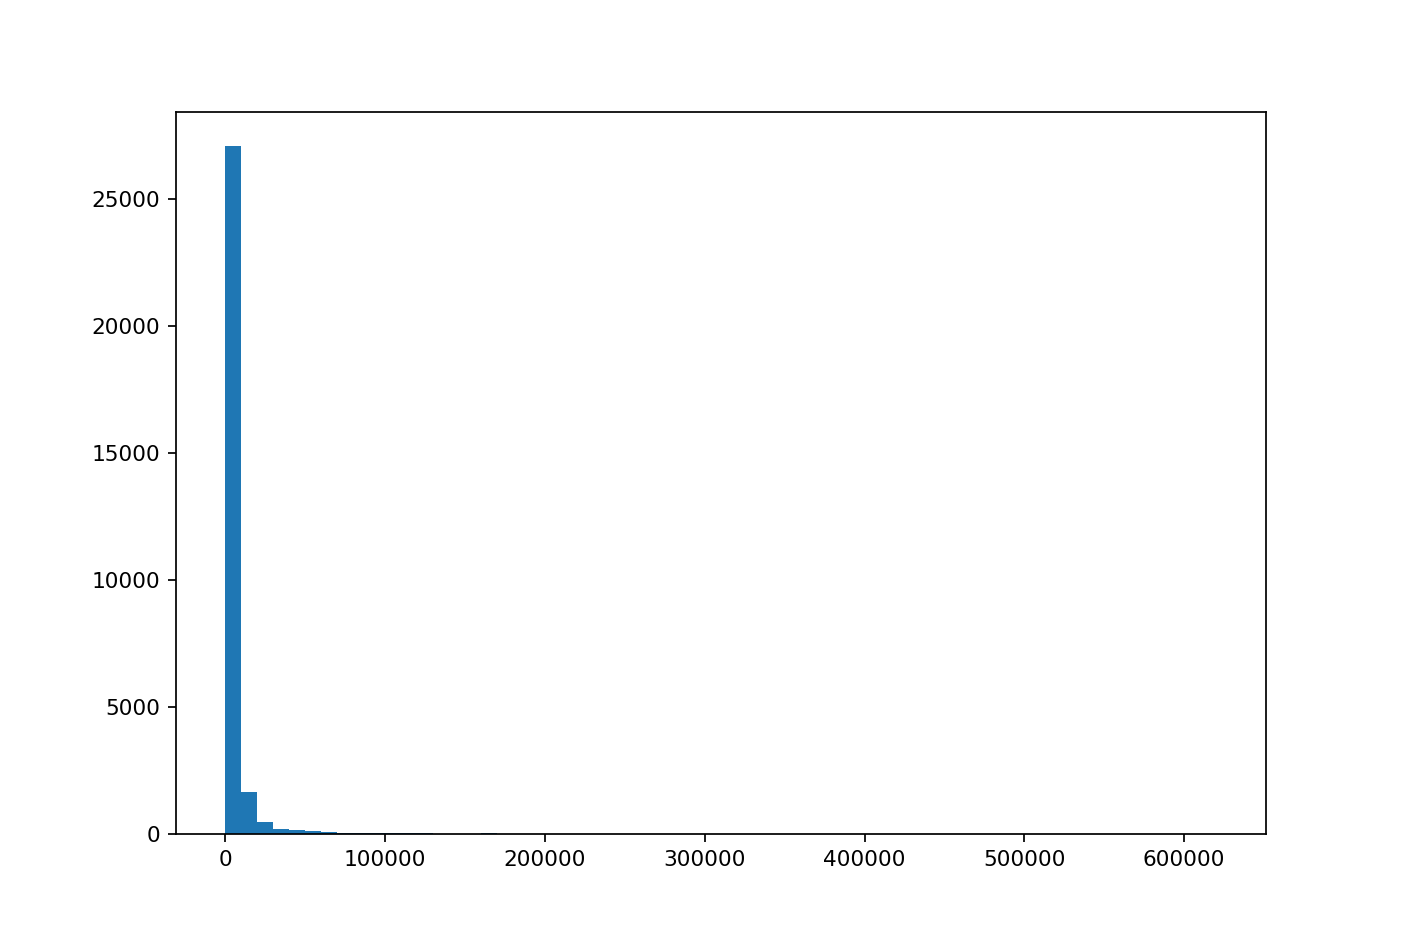

In [95]:
bin_min = rounddown((df["PAY_AMT4"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT4"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT4"],
        bins = bins_range)
plt.show()

### PAY_AMT5

In [96]:
df["PAY_AMT5"] = pd.to_numeric(df["PAY_AMT5"], errors='coerce')

In [97]:
df["PAY_AMT5"].describe()

count     30000.000000
mean       4799.387633
std       15278.305679
min           0.000000
25%         252.500000
50%        1500.000000
75%        4031.500000
max      426529.000000
Name: PAY_AMT5, dtype: float64

<IPython.core.display.Javascript object>


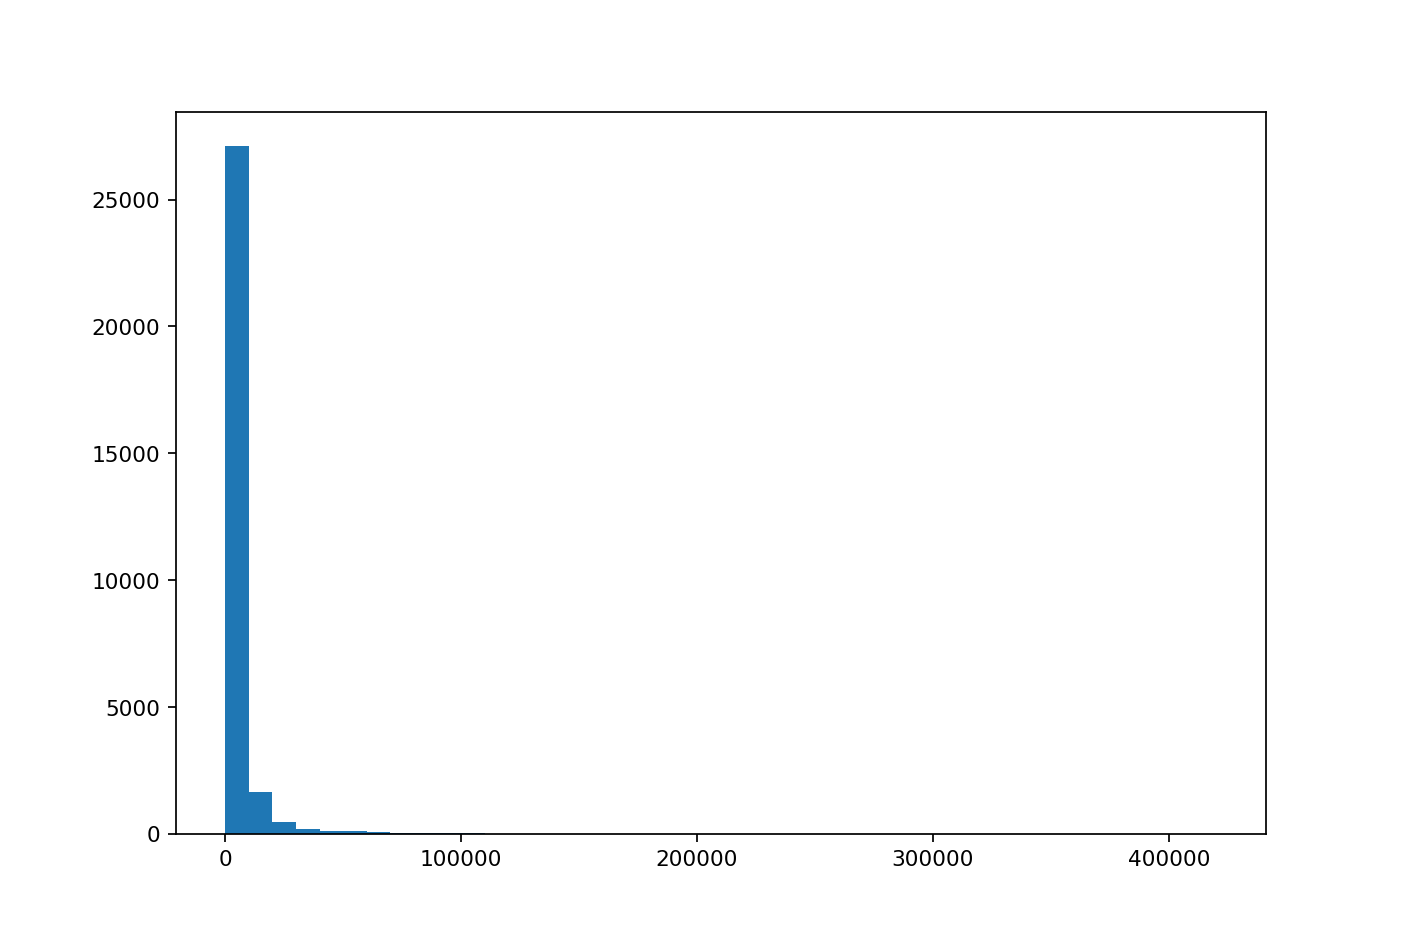

In [98]:
bin_min = rounddown((df["PAY_AMT5"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT5"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT5"],
        bins = bins_range)
plt.show()

### PAY_AMT6

In [99]:
df["PAY_AMT6"] = pd.to_numeric(df["PAY_AMT6"], errors='coerce')

In [100]:
df["PAY_AMT6"].describe()

count     30000.000000
mean       5215.502567
std       17777.465775
min           0.000000
25%         117.750000
50%        1500.000000
75%        4000.000000
max      528666.000000
Name: PAY_AMT6, dtype: float64

<IPython.core.display.Javascript object>


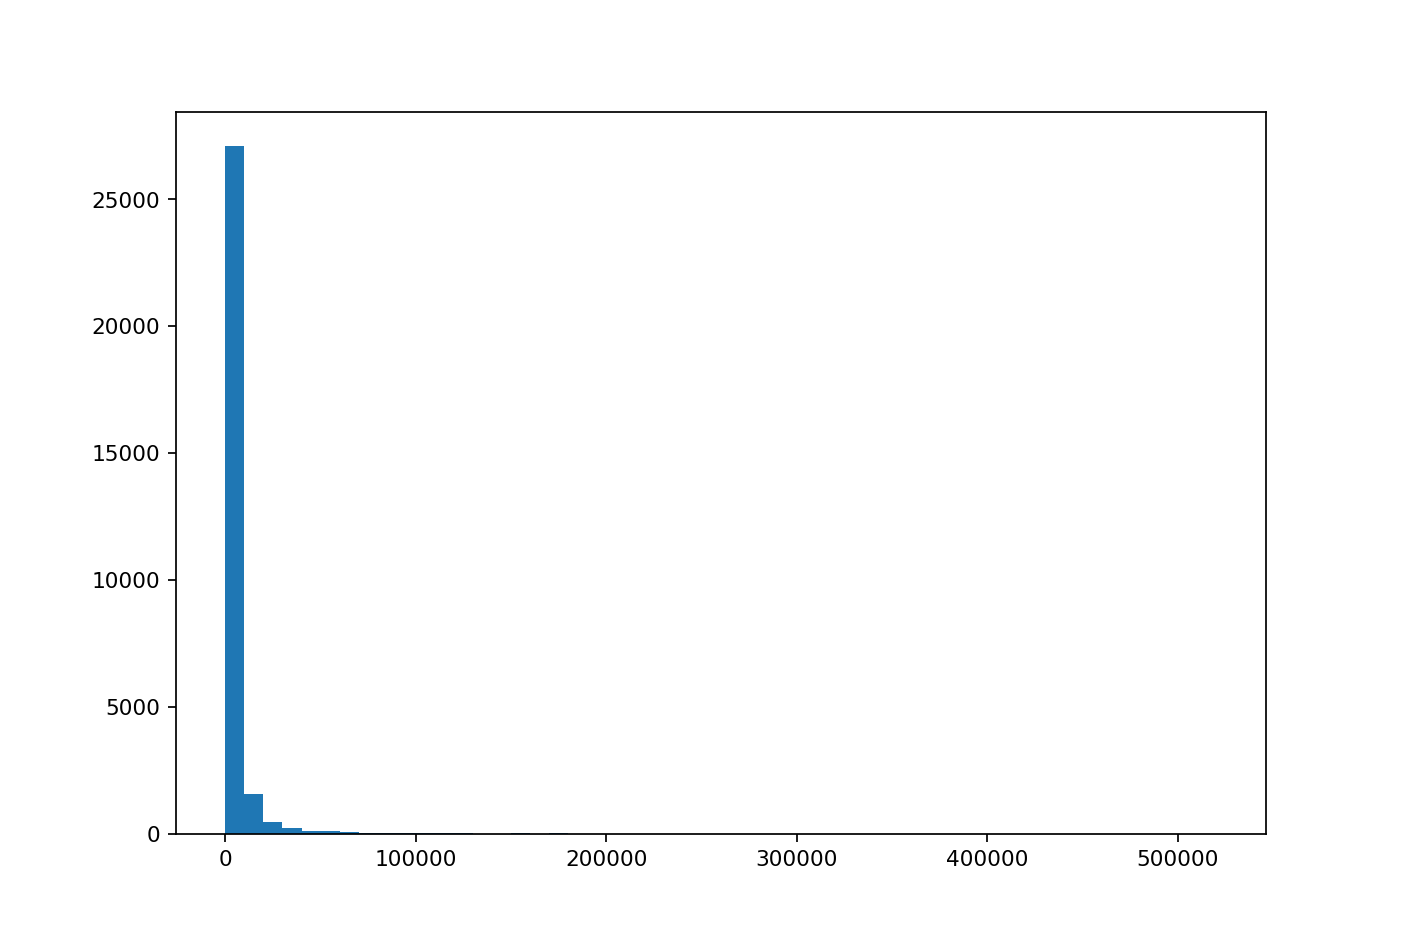

In [101]:
bin_min = rounddown((df["PAY_AMT6"].min(axis=0)),1000)
bin_max = roundup((df["PAY_AMT6"].max(axis=0)),10000)
bins_range = list(range(bin_min,bin_max,10000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["PAY_AMT6"],
        bins = bins_range)
plt.show()

In [102]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Bivariate Analysis

### SEX, MARRIAGE, EDUCATION AND PAY_0 THROUGH PAY 6 all seem to have statisitically significant relationships with default_initial.

### default_initial vs SEX

In [103]:
# form crosstab with dropna=True (default) 
pd.crosstab(df["default_initial"], df["SEX"], normalize = 'columns')

SEX,1,2
default_initial,,
0,0.758328,0.792237
1,0.241672,0.207763


In [104]:
table = pd.crosstab(df["default_initial"], df["SEX"])
c, p, dof, expected = chi2_contingency(table)
print(f'The p-value is {p:.35f}.')

The p-value is 0.00000000000494467899941204434042856.


### default_initial vs MARRIAGE

In [105]:
# form crosstab with dropna=True (default) 
pd.crosstab(df["default_initial"], df["MARRIAGE"], normalize = 'columns')

MARRIAGE,0,1,2,3
default_initial,,,,
0,0.907407,0.765283,0.790717,0.739938
1,0.092593,0.234717,0.209283,0.260062


In [106]:
table = pd.crosstab(df["default_initial"], df["MARRIAGE"])
c, p, dof, expected = chi2_contingency(table)
print(f'The p-value is {p:.35f}.')

The p-value is 0.00000008825862457577375176920591194.


### default_initial vs EDUCATION

In [107]:
# form crosstab with dropna=True (default) 
pd.crosstab(df["default_initial"], df["EDUCATION"], normalize = 'columns')

EDUCATION,0,1,2,3,4,5,6
default_initial,,,,,,,
0,1.0,0.807652,0.762651,0.748424,0.943089,0.935714,0.843137
1,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863


In [108]:
table = pd.crosstab(df["default_initial"], df["EDUCATION"])
c, p, dof, expected = chi2_contingency(table)
print(f'The p-value is {p:.35f}.')

The p-value is 0.00000000000000000000000000000001233.


### default_initial vs PAY_0

In [109]:
anderson(df["PAY_0"])

AndersonResult(statistic=1531.5950129093835, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.0167, scale=1.1238015279973212)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [110]:
group_default = df.loc[df['default_initial'] == '1']['PAY_0']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_0']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=106935081.5, pvalue=0.0)

### default_initial vs PAY_1

In [111]:
anderson(df["PAY_1"])

AndersonResult(statistic=1684.6433295928073, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.07523333333333333, scale=1.061230803948775)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [112]:
group_default = df.loc[df['default_initial'] == '1']['PAY_1']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_1']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=105631765.0, pvalue=0.0)

### default_initial vs PAY_2

In [113]:
anderson(df["PAY_2"])

AndersonResult(statistic=2140.2649146996737, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.13376666666666667, scale=1.19718597303439)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [114]:
group_default = df.loc[df['default_initial'] == '1']['PAY_2']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_2']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=99003557.5, pvalue=6.446010213597527e-309)

### default_initial vs PAY_3

In [115]:
anderson(df["PAY_3"])

AndersonResult(statistic=2131.436343380905, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.1662, scale=1.1968675684467378)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [116]:
group_default = df.loc[df['default_initial'] == '1']['PAY_3']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_3']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=96800760.0, pvalue=1.7860671914718247e-249)

### default_initial vs PAY_4

In [117]:
anderson(df["PAY_4"])

AndersonResult(statistic=2285.037388194869, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.22066666666666668, scale=1.1691386224022984)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [118]:
group_default = df.loc[df['default_initial'] == '1']['PAY_4']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_4']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=94523110.5, pvalue=7.9876431050771735e-199)

### default_initial vs PAY_5

In [119]:
anderson(df["PAY_5"])

AndersonResult(statistic=2428.906423739667, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.2662, scale=1.1331874060026166)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [120]:
group_default = df.loc[df['default_initial'] == '1']['PAY_5']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_5']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=92950283.5, pvalue=4.854524468043771e-167)

### default_initial vs PAY_6

In [121]:
anderson(df["PAY_6"])

AndersonResult(statistic=2250.0119127049875, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.2911, scale=1.1499876256077741)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [122]:
group_default = df.loc[df['default_initial'] == '1']['PAY_6']
group_nodefault = df.loc[df['default_initial'] == '0']['PAY_6']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=91505621.5, pvalue=1.537168874705074e-134)

# Exploring New Features

## bp_gap

In [123]:
df.insert(len(df.columns)-1, 'bill_am_trend', df.apply(bill_trend_fun, axis = 1))

In [124]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bill_am_trend,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,844.571429,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-247.857143,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1854.714286,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4743.257143,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-2231.514286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,41998.142857,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-204.228571,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4250.228571,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-852.657143,1


In [125]:
df.insert(len(df.columns)-1, 'pay_am_trend', df.apply(payam_trend_fun, axis = 1))

In [126]:
df["bp_gap"] = df["bill_am_trend"] - df["pay_am_trend"]
df.drop(['bill_am_trend','pay_am_trend'], axis=1, inplace=True)

In [127]:
col = df.pop('bp_gap')
df.insert(len(df.columns)-1, 'bp_gap', col)

In [128]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1


In [129]:
df["bp_gap"].describe()

count     30000.000000
mean       2460.164544
std       10231.405234
min     -245341.542857
25%        -781.550000
50%         100.285714
75%        4032.471429
max      134462.714286
Name: bp_gap, dtype: float64

<IPython.core.display.Javascript object>


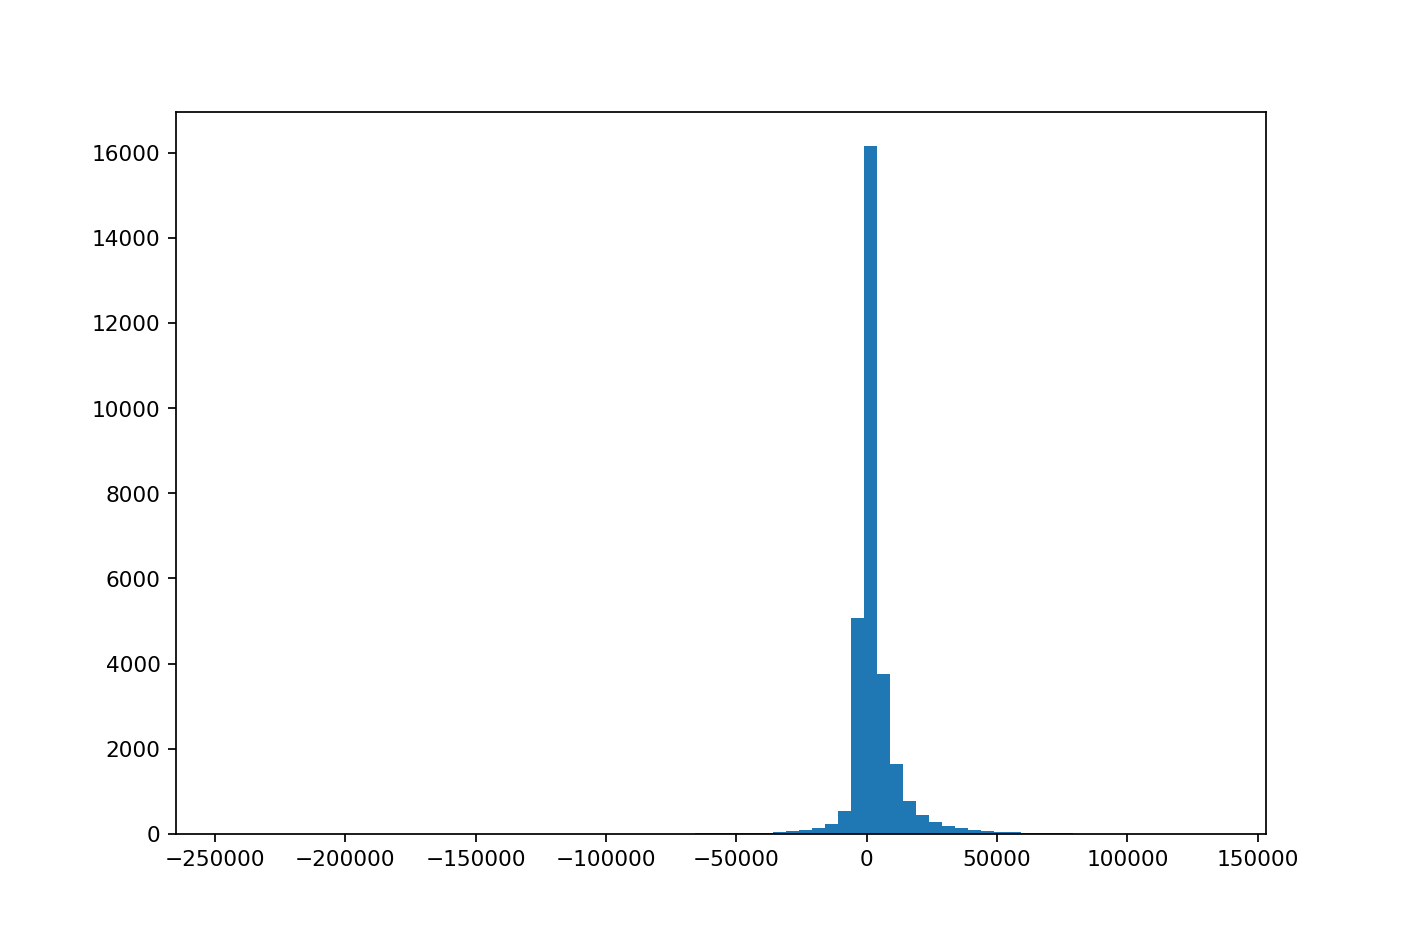

In [130]:
bin_min = rounddown((df["bp_gap"].min(axis=0)),1000)
bin_max = roundup((df["bp_gap"].max(axis=0)),1000)
bins_range = list(range(bin_min,bin_max,5000))
plt.figure(figsize=(9,6))
plt.ticklabel_format(useOffset=True, style='plain')
plt.hist(df["bp_gap"], bins = bins_range)
plt.show()

In [131]:
anderson(df["bp_gap"])

AndersonResult(statistic=3030.555218370806, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2460.164543809524, scale=10231.405234281485)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [132]:
group_default = df.loc[df['default_initial'] == '1']['bp_gap']
group_nodefault = df.loc[df['default_initial'] == '0']['bp_gap']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=71070359.0, pvalue=3.6763152301036385e-25)

## pay_am_variance

In [133]:
df.insert(len(df.columns)-1, 'pay_am_variance', df.apply(payam_variance_fun, axis = 1))

In [134]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,1


In [135]:
df["pay_am_variance"].describe()

count    3.000000e+04
mean     2.588828e+08
std      3.569859e+09
min      0.000000e+00
25%      3.786601e+05
50%      1.998531e+06
75%      1.703178e+07
max      4.226279e+11
Name: pay_am_variance, dtype: float64

In [136]:
anderson(df["pay_am_variance"])

AndersonResult(statistic=10146.141620469367, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=258882783.23356113, scale=3569858532.90907)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [137]:
group_default = df.loc[df['default_initial'] == '1']['pay_am_variance']
group_nodefault = df.loc[df['default_initial'] == '0']['pay_am_variance']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=66795495.0, pvalue=1.5868991587892353e-66)

## pay_trend

In [138]:
df.insert(len(df.columns)-1, 'pay_trend', df.apply(pay_trend_fun, axis = 1))

In [139]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,1


In [140]:
df["pay_trend"].describe()

count    30000.000000
mean         0.046144
std          0.198776
min         -1.285714
25%          0.000000
50%          0.000000
75%          0.107143
max          1.071429
Name: pay_trend, dtype: float64

In [141]:
anderson(df["pay_trend"])

AndersonResult(statistic=1999.1107391406404, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.04614404761904761, scale=0.19877553243233936)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [142]:
group_default = df.loc[df['default_initial'] == '1']['pay_trend']
group_nodefault = df.loc[df['default_initial'] == '0']['pay_trend']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=89554295.5, pvalue=8.154187618671043e-94)

## pay_avg

In [143]:
df.insert(len(df.columns)-1, 'pay_avg', df.apply(pay_avg_fun, axis = 1))

In [144]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,pay_avg,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,2.0,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,0.5,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0.0,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0.0,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,-0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0.0,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,-1.0,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,3.5,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,0.0,1


In [145]:
df["pay_trend"].describe()

count    30000.000000
mean         0.046144
std          0.198776
min         -1.285714
25%          0.000000
50%          0.000000
75%          0.107143
max          1.071429
Name: pay_trend, dtype: float64

In [146]:
anderson(df["pay_trend"])

AndersonResult(statistic=1999.1107391406404, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.04614404761904761, scale=0.19877553243233936)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [147]:
group_default = df.loc[df['default_initial'] == '1']['pay_trend']
group_nodefault = df.loc[df['default_initial'] == '0']['pay_trend']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=89554295.5, pvalue=8.154187618671043e-94)

## customer_forgot

In [148]:
df.insert(len(df.columns)-1, 'customer_forgot', df.apply(customer_forgot, axis = 1))

In [149]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,pay_avg,customer_forgot,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,2.0,0,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,0.5,1,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0.0,0,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0.0,0,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,-0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0.0,0,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,-1.0,1,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,3.5,0,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,0.0,0,1


In [150]:
df["customer_forgot"] = df["customer_forgot"].astype('category')
df["customer_forgot"].dtype

CategoricalDtype(categories=['0', '1'], ordered=False, categories_dtype=object)

In [151]:
df["customer_forgot"].describe()

count     30000
unique        2
top           0
freq      24748
Name: customer_forgot, dtype: object

In [152]:
# form crosstab with dropna=True (default) 
pd.crosstab(df["default_initial"], df["customer_forgot"], normalize = 'columns')

customer_forgot,0,1
default_initial,,
0,0.785963,0.74505
1,0.214037,0.25495


In [153]:
table = pd.crosstab(df["default_initial"], df["SEX"])
c, p, dof, expected = chi2_contingency(table)
print(f'The p-value is {p:.35f}.')

The p-value is 0.00000000000494467899941204434042856.


## num_past_def

In [154]:
df.insert(len(df.columns)-1, 'num_past_def', df.apply(num_past_def_fun, axis = 1))

In [155]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,pay_avg,customer_forgot,num_past_def,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,2.0,0,1,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,0.5,1,2,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0.0,0,0,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0.0,0,0,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,-0.5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0.0,0,0,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,-1.0,1,1,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,3.5,0,2,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,0.0,0,1,1


In [156]:
anderson(df["num_past_def"])

AndersonResult(statistic=4159.361056211572, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5455, scale=0.8988641064642275)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [157]:
group_default = df.loc[df['default_initial'] == '1']['num_past_def']
group_nodefault = df.loc[df['default_initial'] == '0']['num_past_def']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=99877046.0, pvalue=0.0)

In [158]:
df["num_past_def"] = df["num_past_def"].astype('category')
df["num_past_def"].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5], ordered=False, categories_dtype=int64)

In [159]:
df["num_past_def"].describe()

count     30000
unique        6
top           0
freq      19451
Name: num_past_def, dtype: int64

## extra_cash_ratio

In [160]:
df.insert(len(df.columns)-1, 'extra_cash_ratio', df.apply(extra_cash_ratio_fun, axis = 1))

In [161]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,pay_avg,customer_forgot,num_past_def,extra_cash_ratio,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,2.0,0,1,0.00000,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,0.5,1,2,0.00000,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0.0,0,0,0.00000,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0.0,0,0,0.00000,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,-0.5,0,0,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0.0,0,0,0.00000,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,-1.0,1,1,0.00000,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,3.5,0,2,0.00000,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,0.0,0,1,0.03702,1


In [162]:
anderson(df["extra_cash_ratio"])

AndersonResult(statistic=11484.616381320026, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=47.590872226215325, scale=2608.7107479696374)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [163]:
group_default = df.loc[df['default_initial'] == '1']['extra_cash_ratio']
group_nodefault = df.loc[df['default_initial'] == '0']['extra_cash_ratio']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=75938717.0, pvalue=2.2453762226722066e-09)

In [164]:
df["extra_cash_ratio"].describe()

count     30000.000000
mean         47.590872
std        2608.710748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      339603.000000
Name: extra_cash_ratio, dtype: float64

## limit_bal_ratio

In [165]:
df.insert(len(df.columns)-1, 'limit_bal_ratio', df.apply(limit_bal_ratio_fun, axis = 1))

In [166]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,bp_gap,pay_am_variance,pay_trend,pay_avg,customer_forgot,num_past_def,extra_cash_ratio,limit_bal_ratio,default_initial
0,1,20000,2,2,1,24,2.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913,3102,689,0,0,0,0,689,0,0,0,0,785.514286,7.912017e+04,0.821429,2.0,0,1,0.00000,0.128400,1
1,2,120000,2,2,2,26,-1.0,0.5,2.0,0.0,0.0,0.0,2.0,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,-47.857143,5.666667e+05,-0.214286,0.5,1,2,0.00000,0.019692,1
2,3,90000,2,2,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2309.285714,2.464321e+06,0.000000,0.0,0,0,0.00000,0.210463,0
3,4,50000,2,2,1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,4516.114286,2.285396e+05,0.000000,0.0,0,0,0.00000,0.963427,0
4,5,50000,1,2,1,57,-1.0,-0.5,0.0,-1.0,0.0,0.0,0.0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-5533.828571,1.900602e+08,-0.142857,-0.5,0,0,0.00000,0.334147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,39585.114286,4.616276e+07,0.000000,0.0,0,0,0.00000,0.894133,0
29996,29997,150000,1,3,2,43,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1022.285714,1.235891e+07,-0.178571,-1.0,1,1,0.00000,0.015584,0
29997,29998,30000,1,2,2,37,4.0,3.5,3.0,2.0,-1.0,0.0,0.0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,-4144.514286,7.039367e+07,0.821429,3.5,0,2,0.00000,0.107544,1
29998,29999,80000,1,3,1,41,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,-8597.428571,1.318719e+09,0.178571,0.0,0,1,0.03702,0.637658,1


In [167]:
anderson(df["limit_bal_ratio"])

AndersonResult(statistic=1398.871125805421, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4090306305980202, scale=0.3906594017839484)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [168]:
group_default = df.loc[df['default_initial'] == '1']['limit_bal_ratio']
group_nodefault = df.loc[df['default_initial'] == '0']['limit_bal_ratio']
stats.mannwhitneyu(group_default,group_nodefault, alternative='two-sided')

MannwhitneyuResult(statistic=86252391.5, pvalue=1.1194654914820864e-44)

In [169]:
df["extra_cash_ratio"].describe()

count     30000.000000
mean         47.590872
std        2608.710748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      339603.000000
Name: extra_cash_ratio, dtype: float64

## New Feature Correlation Check

### A correlation plot among the newly created features does not indicate any ridiculous-looking correlations - which is generally is what we would want to see.  If there were more significant correlations, I might consider dropping one of the added features - perhaps starting with pay_avg.

<IPython.core.display.Javascript object>


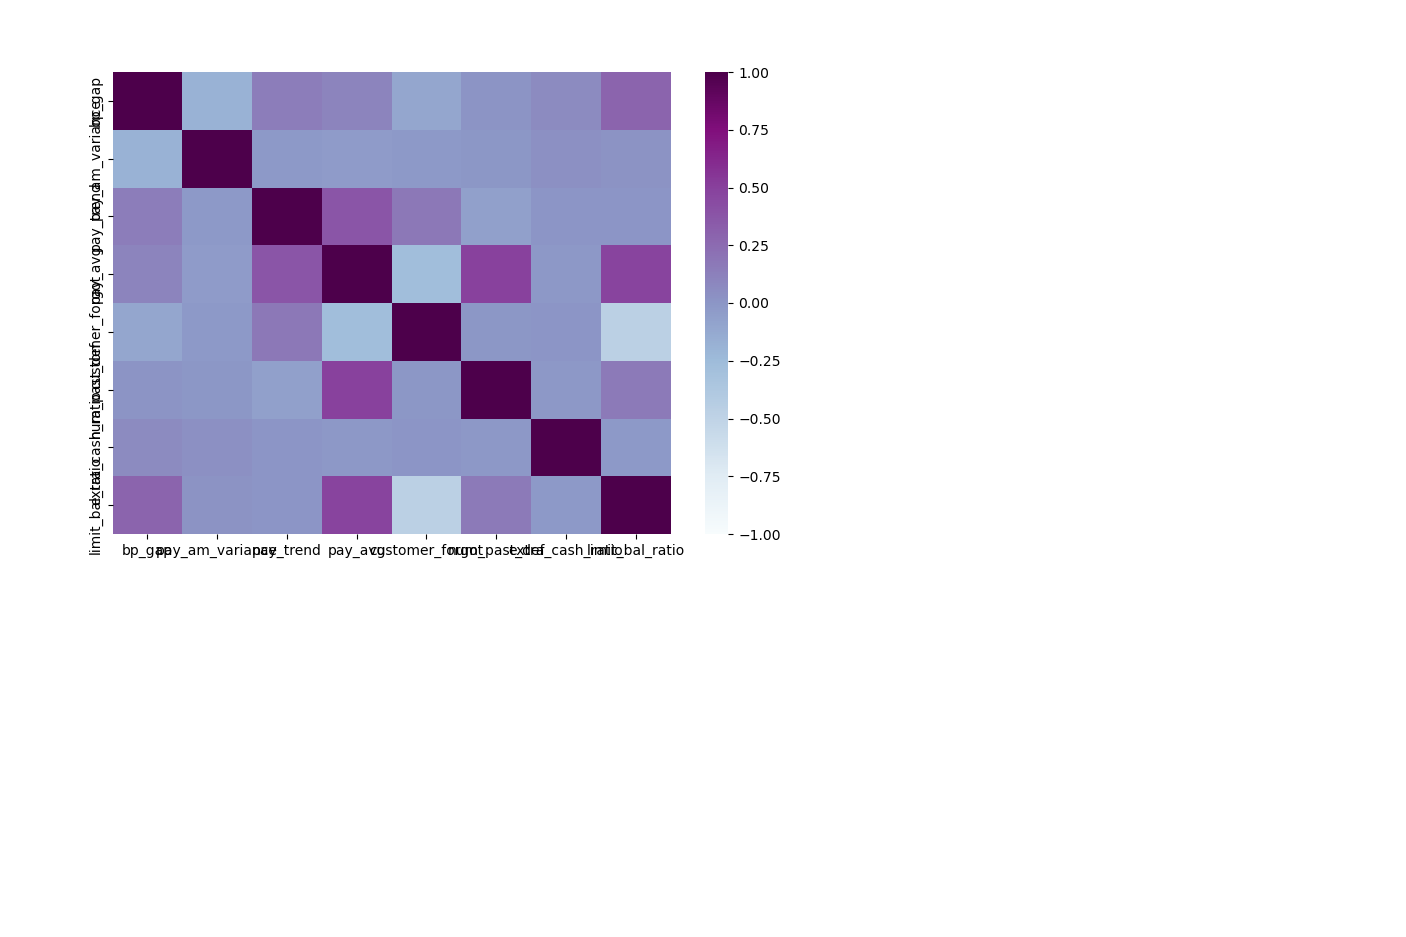

In [170]:
corr2 = df[['bp_gap','pay_am_variance','pay_trend','pay_avg',
            'customer_forgot','num_past_def','extra_cash_ratio','limit_bal_ratio']].corr()

plt.figure(figsize=(9,6))
sn.heatmap(corr2, annot=True, vmin=-1.0,cmap='BuPu')
plt.title("Initial Correlation Assessment")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ID                30000 non-null  object  
 1   LIMIT_BAL         30000 non-null  int64   
 2   SEX               30000 non-null  category
 3   EDUCATION         30000 non-null  category
 4   MARRIAGE          30000 non-null  category
 5   AGE               30000 non-null  int64   
 6   PAY_0             30000 non-null  float64 
 7   PAY_1             30000 non-null  float64 
 8   PAY_2             30000 non-null  float64 
 9   PAY_3             30000 non-null  float64 
 10  PAY_4             30000 non-null  float64 
 11  PAY_5             30000 non-null  float64 
 12  PAY_6             30000 non-null  float64 
 13  BILL_AMT1         30000 non-null  int64   
 14  BILL_AMT2         30000 non-null  int64   
 15  BILL_AMT3         30000 non-null  int64   
 16  BILL_AMT4         3000

# Attend Pre-Processing

In [172]:
def preprocessing_main(df):
    
    working = df.copy()
    
    # appying one hot encoding to nominal categorical items

    ohe_1 = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
    ohetransform = ohe_1.fit_transform(working[['SEX']])
    working = pd.concat([working,ohetransform],axis=1).drop(columns = ['SEX'])
    
    ohe_2 = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
    ohetransform = ohe_2.fit_transform(working[['EDUCATION']])
    working = pd.concat([working,ohetransform],axis=1).drop(columns = ['EDUCATION'])
    
    ohe_3 = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
    ohetransform = ohe_3.fit_transform(working[['MARRIAGE']])
    working = pd.concat([working,ohetransform],axis=1).drop(columns = ['MARRIAGE'])
    
    # appying ordinal encoding to customer_forgot and num_past_def
    
    ord_enc_1 = OrdinalEncoder(categories = [['0','1']])
    working['customer_forgot'] = ord_enc_1.fit_transform(working[['customer_forgot']])
    
    ord_enc_2 = OrdinalEncoder(categories = [['0','1','2','3','4','5']])
    working['num_past_def'] = ord_enc_2.fit_transform(working[['num_past_def']])
     
    # Split df into X and y
    target = working['default_initial']
    pre_features = working.drop('default_initial', axis=1)
    
    features_list = ['bp_gap','pay_am_variance','pay_trend','pay_avg',
                     'customer_forgot','num_past_def','extra_cash_ratio','limit_bal_ratio',
                     'LIMIT_BAL',
                     'SEX_1','SEX_2',
                     'EDUCATION_0','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','EDUCATION_5','EDUCATION_6',
                     'MARRIAGE_0','MARRIAGE_1','MARRIAGE_2','MARRIAGE_3',
                     'AGE']
    
    features = pre_features[features_list]
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    
    return features, target

In [173]:
features, target = preprocessing_main(df)

In [174]:
features

,bp_gap,pay_am_variance,pay_trend,pay_avg,customer_forgot,num_past_def,extra_cash_ratio,limit_bal_ratio,LIMIT_BAL,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,AGE
0,-0.163680,-0.072498,3.900367,1.955529,-0.460673,0.505647,-0.018243,-0.718363,-1.136720,-0.810161,0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,-1.246020
1,-0.245134,-0.072362,-1.310192,0.542053,2.170739,1.618180,-0.018243,-0.996637,-0.365981,-0.810161,0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,-1.029047
2,-0.014747,-0.071830,-0.232145,0.070894,-0.460673,-0.606887,-0.018243,-0.508297,-0.597202,-0.810161,0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,-0.161156
3,0.200948,-0.072456,-0.232145,0.070894,-0.460673,-0.606887,-0.018243,1.419153,-0.905498,-0.810161,0.810161,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0.164303
4,-0.781332,-0.019279,-0.950843,-0.400265,-0.460673,-0.606887,-0.018243,-0.191689,-0.905498,1.234323,-1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,2.334029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,3.628589,-0.059589,-0.232145,0.070894,-0.460673,-0.606887,-0.018243,1.241774,0.404759,1.234323,-1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0.381275
29996,-0.340374,-0.069058,-1.130518,-0.871424,2.170739,0.505647,-0.018243,-1.007150,-0.134759,1.234323,-1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0.815221
29997,-0.645541,-0.052801,3.900367,3.369006,-0.460673,1.618180,-0.018243,-0.771750,-1.059646,1.234323,-1.234323,-0.021608,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0.164303
29998,-1.080768,0.296890,0.666227,0.070894,-0.460673,0.505647,-0.018229,0.585245,-0.674276,1.234323,-1.234323,-0.021608,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0.598248


<IPython.core.display.Javascript object>


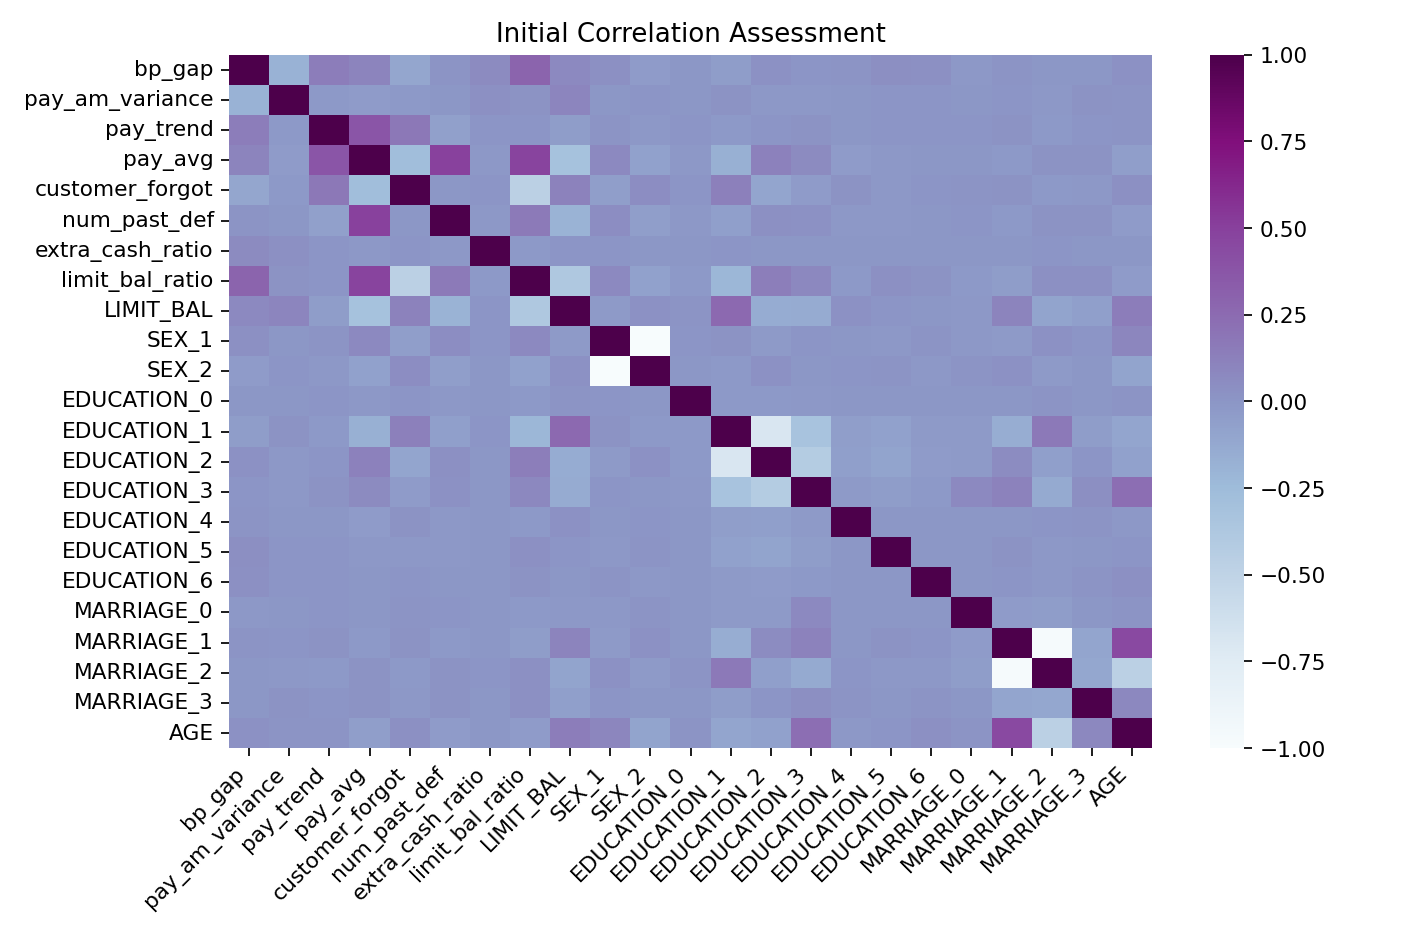

In [175]:
corr2 = features.corr()

plt.figure(figsize=(9,6))
sn.heatmap(corr2, annot=False, vmin=-1.0,cmap='BuPu')
plt.title("Initial Correlation Assessment")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [176]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bp_gap            30000 non-null  float64
 1   pay_am_variance   30000 non-null  float64
 2   pay_trend         30000 non-null  float64
 3   pay_avg           30000 non-null  float64
 4   customer_forgot   30000 non-null  float64
 5   num_past_def      30000 non-null  float64
 6   extra_cash_ratio  30000 non-null  float64
 7   limit_bal_ratio   30000 non-null  float64
 8   LIMIT_BAL         30000 non-null  float64
 9   SEX_1             30000 non-null  float64
 10  SEX_2             30000 non-null  float64
 11  EDUCATION_0       30000 non-null  float64
 12  EDUCATION_1       30000 non-null  float64
 13  EDUCATION_2       30000 non-null  float64
 14  EDUCATION_3       30000 non-null  float64
 15  EDUCATION_4       30000 non-null  float64
 16  EDUCATION_5       30000 non-null  float6

# Model Building

In [177]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [5, 10, 25, 50, 100, 200],
            'max_depth': [5, 10, 15, 20, 25, 50],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': ['sqrt',8]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [0.1, 1, 10, 50, 100]
        }
    }
}

In [178]:
recall_scorer = make_scorer(recall_score, pos_label='1')

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring = recall_scorer,
                        cv=5, n_jobs = -1, refit = False, return_train_score=False)
    clf.fit(features,target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_look = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_look

,model,best_score,best_params
0,random_forest,0.381407,"{'max_depth': 20, 'max_features': 8, 'min_samp..."
1,logistic_regression,0.242919,{'C': 10}


In [180]:
df_look['best_params'][0]

{'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 5}